#Loading Data

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
import joblib

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import set_config
set_config(display = 'text')
filename = "sales_predictions.csv"

In [84]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [197]:
def get_coeffs_linreg(linreg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = linreg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(linreg.coef_, index= feature_names)
    coeffs['intercept'] = linreg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

In [2]:
sales_pred_df = pd.read_csv(filename)
display(sales_pred_df.head())
sales_pred_df.info()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Data Cleaning

## # 1.  How many rows and columns? 

In [3]:
sales_pred_df.shape

(8523, 12)

## #2. What are the datatypes of each variable?

In [4]:
sales_pred_df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

## # 3. Are there duplicates? If so, drop any duplicates.

In [5]:
# 3. Are there duplicates? If so, drop any duplicates.
sales_pred_df.duplicated().sum()

0

## # 4. Identify missing values.

In [6]:
# 4. Identify missing values.
sales_pred_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## # 5. Decide on how to address the missing values and do it! 

In [7]:
# 5. Decide on how to address the missing values and do it! 
sales_pred_df.dropna(subset=['Item_Weight'], inplace=True) # dropping "Item Weight" since the info is not needed for sales predictions.
sales_pred_df.dropna(subset=['Outlet_Size'], inplace=True) # dropping "Outlet Size" since we can get that info on what "Outlet Type" it is.
display(sales_pred_df)
sales_pred_df.info()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
...,...,...,...,...,...,...,...,...,...,...,...,...
8517,FDF53,20.750,reg,0.083607,Frozen Foods,178.8318,OUT046,1997,Small,Tier 1,Supermarket Type1,3608.6360
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4650 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            4650 non-null   object 
 1   Item_Weight                4650 non-null   float64
 2   Item_Fat_Content           4650 non-null   object 
 3   Item_Visibility            4650 non-null   float64
 4   Item_Type                  4650 non-null   object 
 5   Item_MRP                   4650 non-null   float64
 6   Outlet_Identifier          4650 non-null   object 
 7   Outlet_Establishment_Year  4650 non-null   int64  
 8   Outlet_Size                4650 non-null   object 
 9   Outlet_Location_Type       4650 non-null   object 
 10  Outlet_Type                4650 non-null   object 
 11  Item_Outlet_Sales          4650 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 472.3+ KB


## # 6. Confirm that there are no missing values after addressing them.

In [8]:
# 6. Confirm that there are no missing values after addressing them.
sales_pred_df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## # 7. Find and fix any inconsistent categories of data (example: fix cat, Cat, and cats so that they are consistent).

In [9]:
# 7. Find and fix any inconsistent categories of data (example: fix cat, Cat, and cats so that they are consistent).
sales_pred_df['Item_Identifier'].value_counts()

FDH26    5
FDL51    5
FDJ09    5
FDB15    5
FDC17    5
        ..
FDE40    1
FDF50    1
NCA42    1
FDK32    1
FDO03    1
Name: Item_Identifier, Length: 1535, dtype: int64

In [10]:
sales_pred_df['Item_Weight'].value_counts()

12.150    58
17.600    55
13.650    49
11.800    49
16.000    45
          ..
6.965      1
9.035      1
7.260      1
7.360      1
6.440      1
Name: Item_Weight, Length: 409, dtype: int64

In [11]:
sales_pred_df['Item_Fat_Content'].value_counts() # there were inconsistencies in this column

sales_pred_df['Item_Fat_Content'] = sales_pred_df['Item_Fat_Content'].replace('LF', 'Low Fat')
sales_pred_df['Item_Fat_Content'] = sales_pred_df['Item_Fat_Content'].replace('low fat', 'Low Fat')
sales_pred_df['Item_Fat_Content'] = sales_pred_df['Item_Fat_Content'].replace('reg', 'Regular')
sales_pred_df['Item_Fat_Content'].value_counts()

Low Fat    3004
Regular    1646
Name: Item_Fat_Content, dtype: int64

In [12]:
sales_pred_df['Item_Visibility'].value_counts()

0.000000    292
0.076975      3
0.121250      2
0.046825      2
0.026950      2
           ... 
0.039248      1
0.040946      1
0.031332      1
0.026841      1
0.044878      1
Name: Item_Visibility, Length: 4280, dtype: int64

In [13]:
sales_pred_df['Item_Type'].value_counts()

Fruits and Vegetables    670
Snack Foods              656
Household                498
Frozen Foods             477
Dairy                    380
Canned                   361
Baking Goods             351
Health and Hygiene       277
Soft Drinks              241
Meat                     221
Breads                   132
Hard Drinks              117
Others                    91
Starchy Foods             87
Breakfast                 58
Seafood                   33
Name: Item_Type, dtype: int64

In [14]:
sales_pred_df['Item_MRP'].value_counts()

142.0154    6
172.0422    4
100.1016    4
146.9102    4
163.1184    3
           ..
156.4972    1
146.5418    1
51.0324     1
57.3930     1
75.4670     1
Name: Item_MRP, Length: 3806, dtype: int64

In [15]:
sales_pred_df['Outlet_Identifier'].value_counts()

OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT018    928
Name: Outlet_Identifier, dtype: int64

In [16]:
sales_pred_df['Outlet_Establishment_Year'].value_counts()

1987    932
1999    930
1997    930
2004    930
2009    928
Name: Outlet_Establishment_Year, dtype: int64

In [17]:
sales_pred_df['Outlet_Size'].value_counts()

Small     1860
Medium    1858
High       932
Name: Outlet_Size, dtype: int64

In [18]:
sales_pred_df['Outlet_Location_Type'].value_counts()

Tier 1    1860
Tier 3    1860
Tier 2     930
Name: Outlet_Location_Type, dtype: int64

In [19]:
sales_pred_df['Outlet_Type'].value_counts()

Supermarket Type1    3722
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [20]:
sales_pred_df['Item_Outlet_Sales'].value_counts()

1342.2528    11
1438.1280    11
958.7520     10
703.0848     10
1845.5976     9
             ..
256.3330      1
3941.5360     1
3858.9768     1
5496.8448     1
2778.3834     1
Name: Item_Outlet_Sales, Length: 2449, dtype: int64

## # 8. For any numerical columns, obtain the summary statistics of each (min, max, mean).

In [21]:
# 8. For any numerical columns, obtain the summary statistics of each (min, max, mean).
sales_pred_df.describe().round()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,4650.0,4650.0,4650.0,4650.0,4650.0
mean,13.0,0.0,142.0,1999.0,2272.0
std,5.0,0.0,62.0,7.0,1498.0
min,5.0,0.0,31.0,1987.0,69.0
25%,9.0,0.0,94.0,1997.0,1125.0
50%,13.0,0.0,143.0,1999.0,1940.0
75%,17.0,0.0,187.0,2004.0,3112.0
max,21.0,0.0,267.0,2009.0,10257.0


# Task 3 
- Histogram to view the distributions of various features in your dataset.
- Boxplot to view statistical summaries of various features in your dataset.
- Heatmap of the correlation between features.


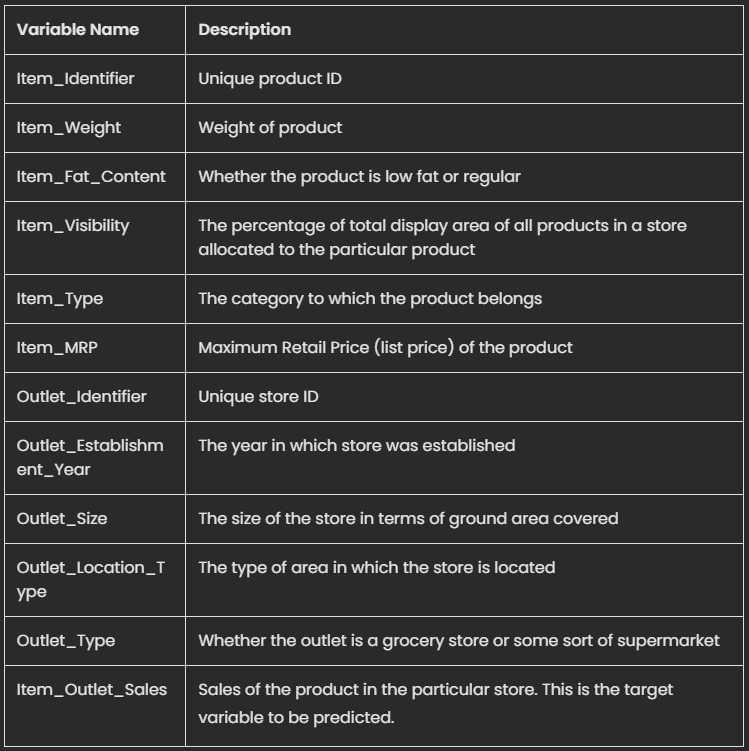

## Histograms


In [23]:
display(sales_pred_df)
sales_pred_df.info()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
...,...,...,...,...,...,...,...,...,...,...,...,...
8517,FDF53,20.750,Regular,0.083607,Frozen Foods,178.8318,OUT046,1997,Small,Tier 1,Supermarket Type1,3608.6360
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4650 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            4650 non-null   object 
 1   Item_Weight                4650 non-null   float64
 2   Item_Fat_Content           4650 non-null   object 
 3   Item_Visibility            4650 non-null   float64
 4   Item_Type                  4650 non-null   object 
 5   Item_MRP                   4650 non-null   float64
 6   Outlet_Identifier          4650 non-null   object 
 7   Outlet_Establishment_Year  4650 non-null   int64  
 8   Outlet_Size                4650 non-null   object 
 9   Outlet_Location_Type       4650 non-null   object 
 10  Outlet_Type                4650 non-null   object 
 11  Item_Outlet_Sales          4650 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 472.3+ KB


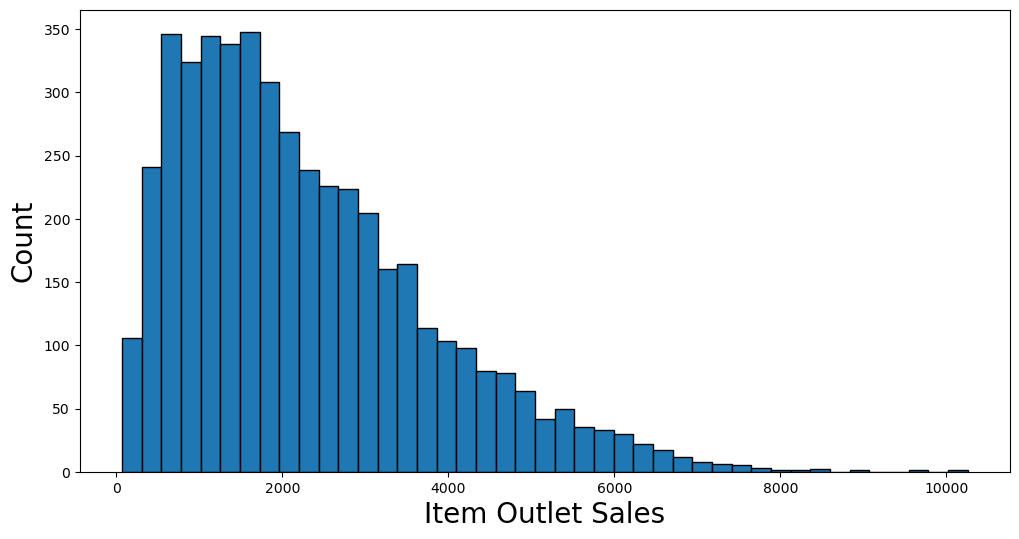

In [24]:
fig, ax = plt.subplots(figsize = (12,6))
ax.hist(sales_pred_df["Item_Outlet_Sales"], edgecolor = "black", bins = 'auto')

ax.set_xlabel("Item Outlet Sales", fontsize = 20)
ax.set_ylabel("Count", fontsize = 20);

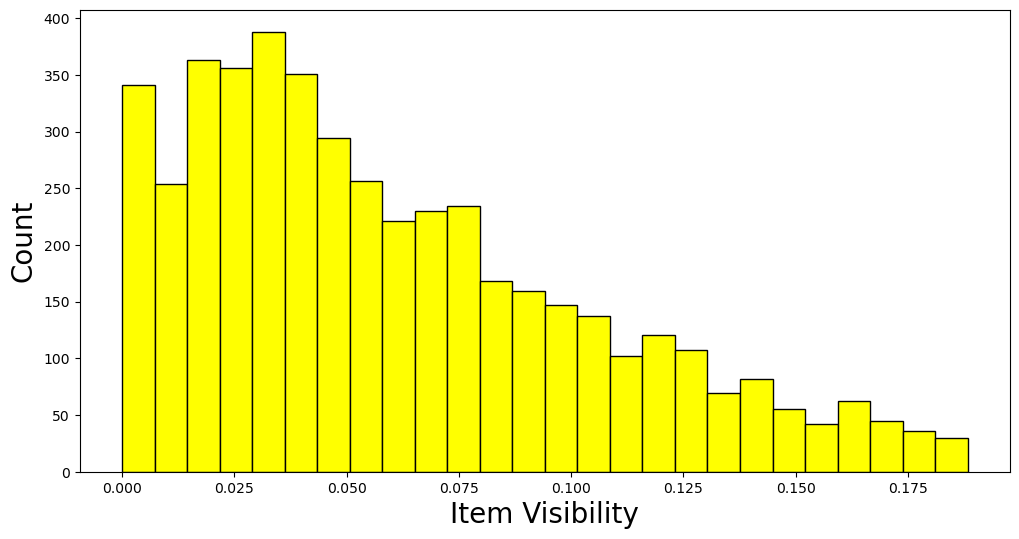

In [25]:
fig, ax = plt.subplots(figsize = (12,6))
ax.hist(sales_pred_df["Item_Visibility"], color = "yellow", 
        edgecolor = "black", bins = 'auto')

ax.set_xlabel("Item Visibility", fontsize = 20)
ax.set_ylabel("Count", fontsize = 20);

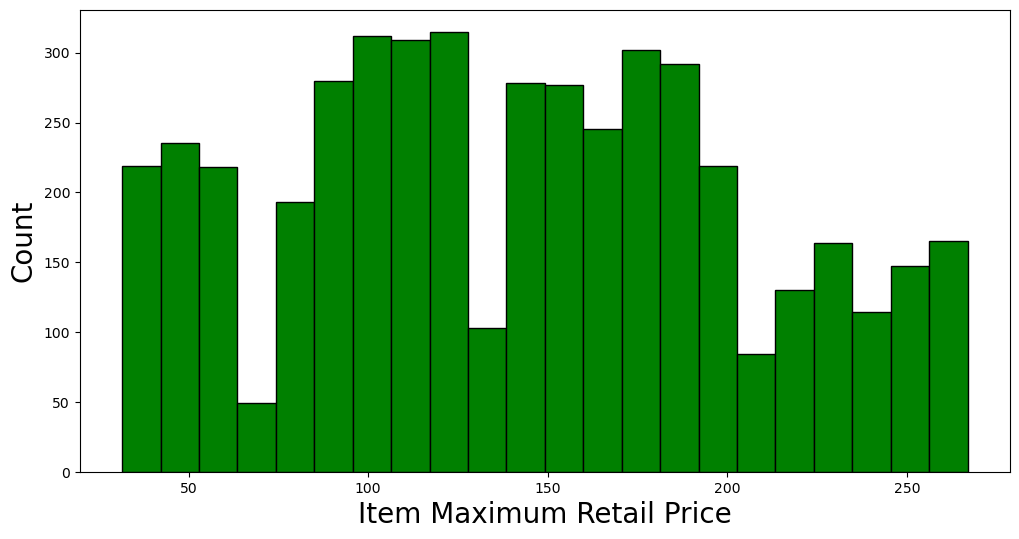

In [26]:
fig, ax = plt.subplots(figsize = (12,6))
ax.hist(sales_pred_df["Item_MRP"], color = "green", edgecolor = "black", 
        bins = "auto",)

ax.set_xlabel("Item Maximum Retail Price", fontsize = 20)
ax.set_ylabel("Count", fontsize = 20);

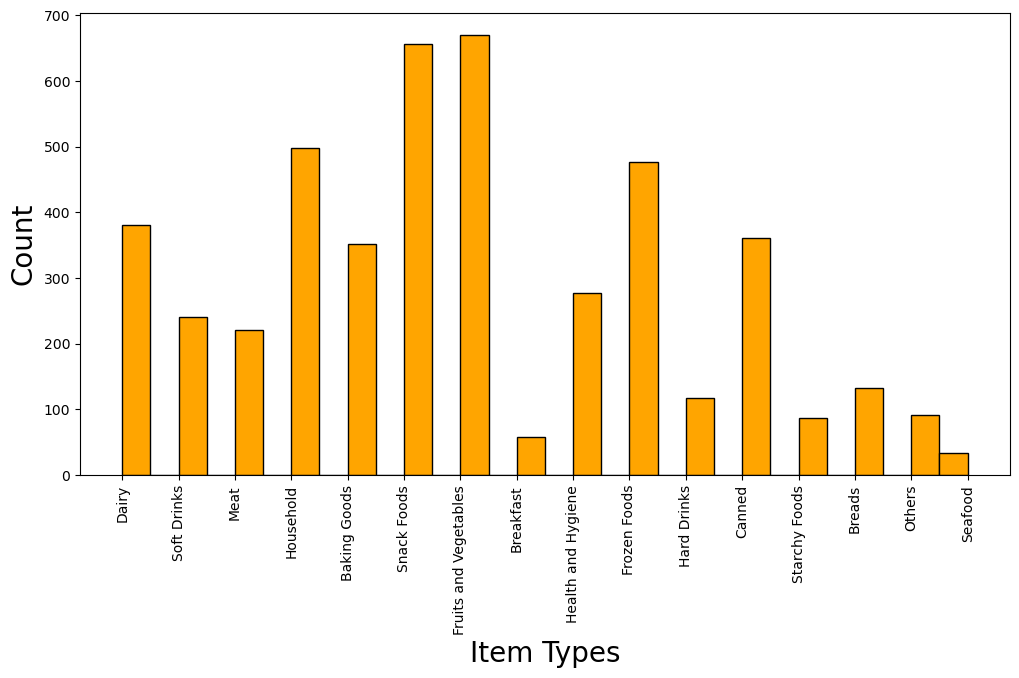

In [27]:
fig, ax = plt.subplots(figsize = (12,6))
ax.hist(sales_pred_df["Item_Type"], color = "orange", edgecolor = "black", 
        bins = 30);

ax.set_xlabel("Item Types", fontsize = 20)
ax.set_ylabel("Count", fontsize = 20)
plt.xticks(rotation = 90);

## Boxplots

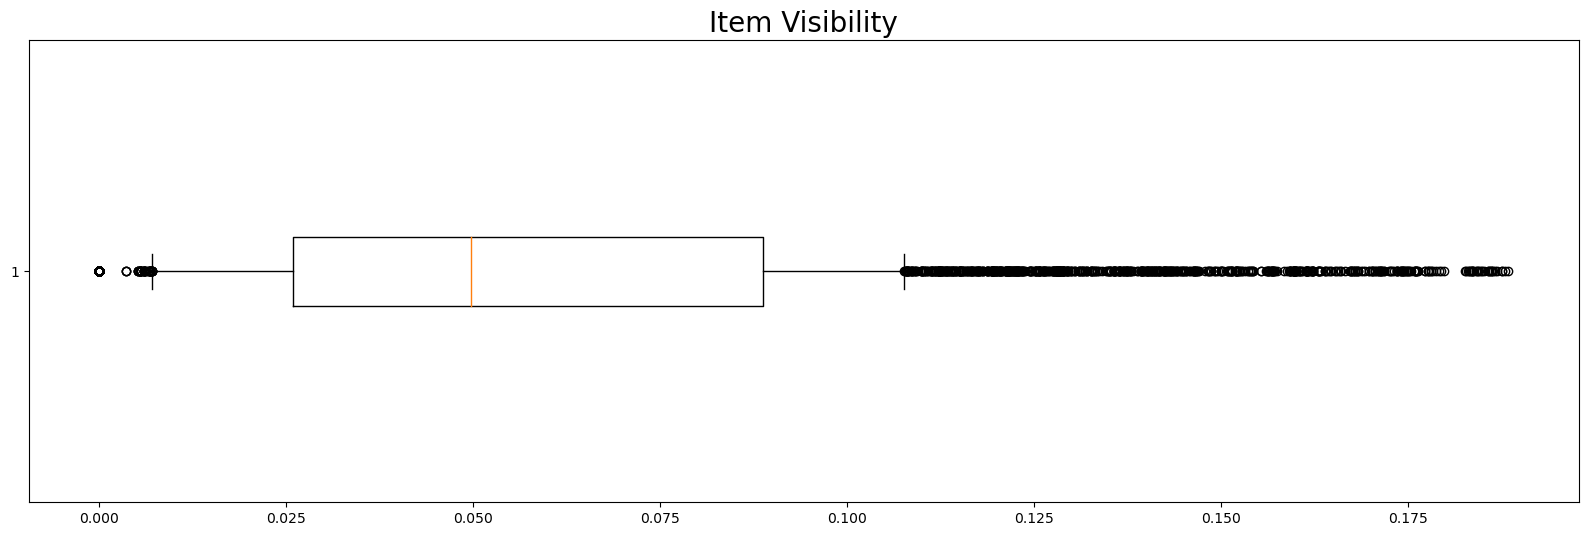

In [28]:
fig, ax = plt.subplots(figsize = (20,6))

ax.set_title("Item Visibility", fontsize = 20)

plt.boxplot(sales_pred_df["Item_Visibility"], vert = False, whis = 0.30);

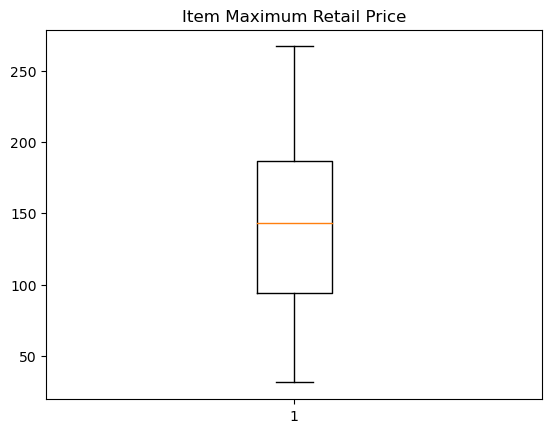

In [29]:
fig, ax = plt.subplots()

ax.set_title("Item Maximum Retail Price")

plt.boxplot(sales_pred_df["Item_MRP"]);

## Heatmaps

C:\Users\spart\AppData\Local\Temp\ipykernel_14540\2831457744.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sales_corr = sales_pred_df.corr()


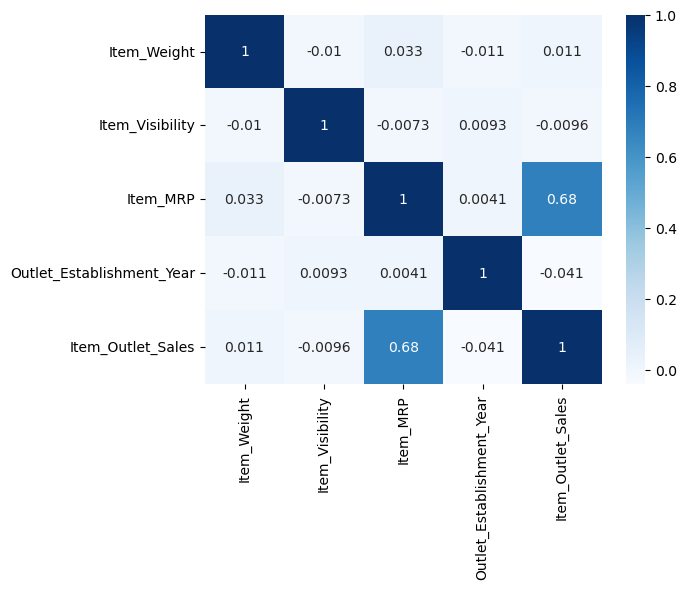

In [30]:
sales_corr = sales_pred_df.corr()

sns.heatmap(sales_corr, cmap = "Blues", annot = True);

# Task 4

- Build on your previous cleaning, exploration, and analysis.
- Create a minimum of two data visualizations that help others understand trends in the data (explanatory data analysis).
- Since these graphs are for reporting purposes, make sure they look nice by including titles, legends, etc.

In [32]:
sales_pred_df["Outlet_Location_Type"].value_counts()

Tier 1    1860
Tier 3    1860
Tier 2     930
Name: Outlet_Location_Type, dtype: int64

## I'm getting the average sales between each location type.

In [33]:
tier_avg = sales_pred_df.groupby("Outlet_Location_Type")[["Item_Outlet_Sales"]].mean()
tier_avg

,Item_Outlet_Sales
Outlet_Location_Type,
Tier 1,2313.099451
Tier 2,2438.841866
Tier 3,2147.573338


In [34]:
loc_type = np.array(tier_avg.index)
loc_type

array(['Tier 1', 'Tier 2', 'Tier 3'], dtype=object)

In [35]:
avg_sales = list(tier_avg.values)
avg_sales

[array([2313.09945075]), array([2438.84186602]), array([2147.57333774])]

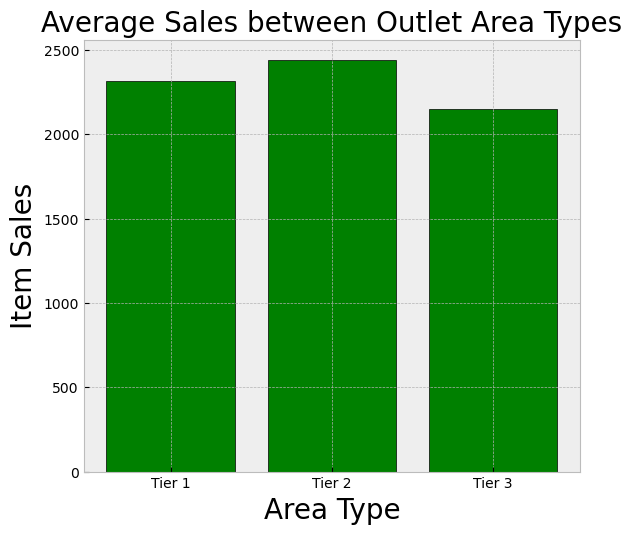

In [36]:
height = [2313.09945075, 2438.84186602, 2147.57333774]

plt.style.use("bmh")
plt.subplots_adjust(top = 1.2, bottom = 0.3)

plt.bar(loc_type, height, edgecolor = "black", color = "Green")

plt.title("Average Sales between Outlet Area Types", fontsize = 20)
plt.xlabel("Area Type", fontsize = 20)
plt.ylabel("Item Sales", fontsize = 20); 

## Highest selling item. Seeing if it correlates with Item Visibility

In [37]:
# Total sales of each item type.
typesales = sales_pred_df.groupby("Item_Type")[["Item_Outlet_Sales"]].sum()
typesales

,Item_Outlet_Sales
Item_Type,
Baking Goods,7.184262e+05
Breads,3.154407e+05
Breakfast,1.277837e+05
Canned,7.960811e+05
Dairy,8.882198e+05
Frozen Foods,1.059900e+06
Fruits and Vegetables,1.549511e+06
Hard Drinks,2.612932e+05
Health and Hygiene,5.922457e+05


In [38]:
typelist = np.array(typesales.index)
typelist

array(['Baking Goods', 'Breads', 'Breakfast', 'Canned', 'Dairy',
       'Frozen Foods', 'Fruits and Vegetables', 'Hard Drinks',
       'Health and Hygiene', 'Household', 'Meat', 'Others', 'Seafood',
       'Snack Foods', 'Soft Drinks', 'Starchy Foods'], dtype=object)

In [39]:
# Total of the item type's visiblity
vislist = sales_pred_df.groupby(["Item_Type"])[["Item_Visibility"]].sum()

Text(0.5, 0, 'Total Item Sales')

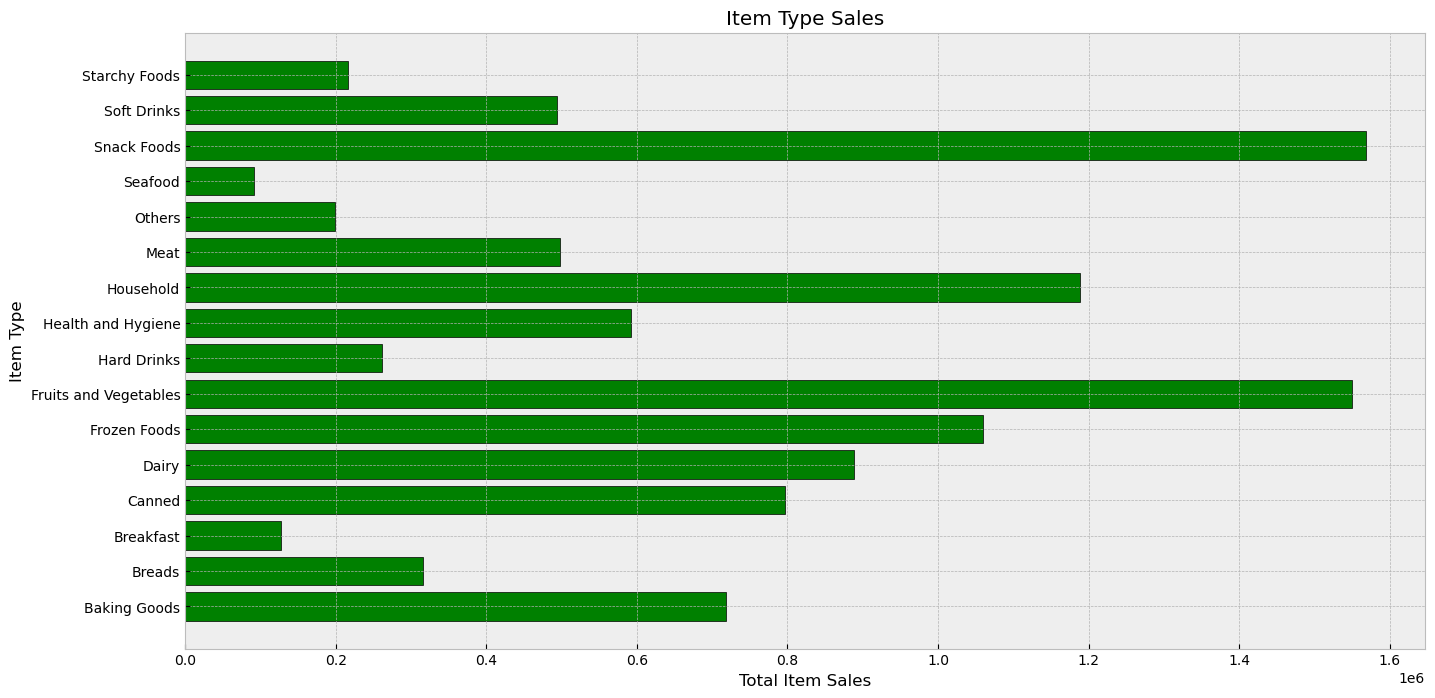

In [40]:
saleslist2 = [718426.1636, 315440.7266, 127783.665, 796081.0808, 888219.8112, 1059899.6702, 1549511.0136, 261293.21, 592245.745, 1188504.2666, 497271.3724, 199671.4226, 
        91813.82, 1568592.1758, 494131.4596, 216088.719]

plt.figure(figsize = (16,8))

plt.barh(typelist, saleslist2, color = "Green", edgecolor = "black")
plt.title("Item Type Sales")
plt.ylabel("Item Type")
plt.xlabel("Total Item Sales")
# plt.ticklabel_format(useOffset=False, style = "plain")

Text(0.5, 0, 'Item Type Total Visiblity \n (0 = No Visibility)')

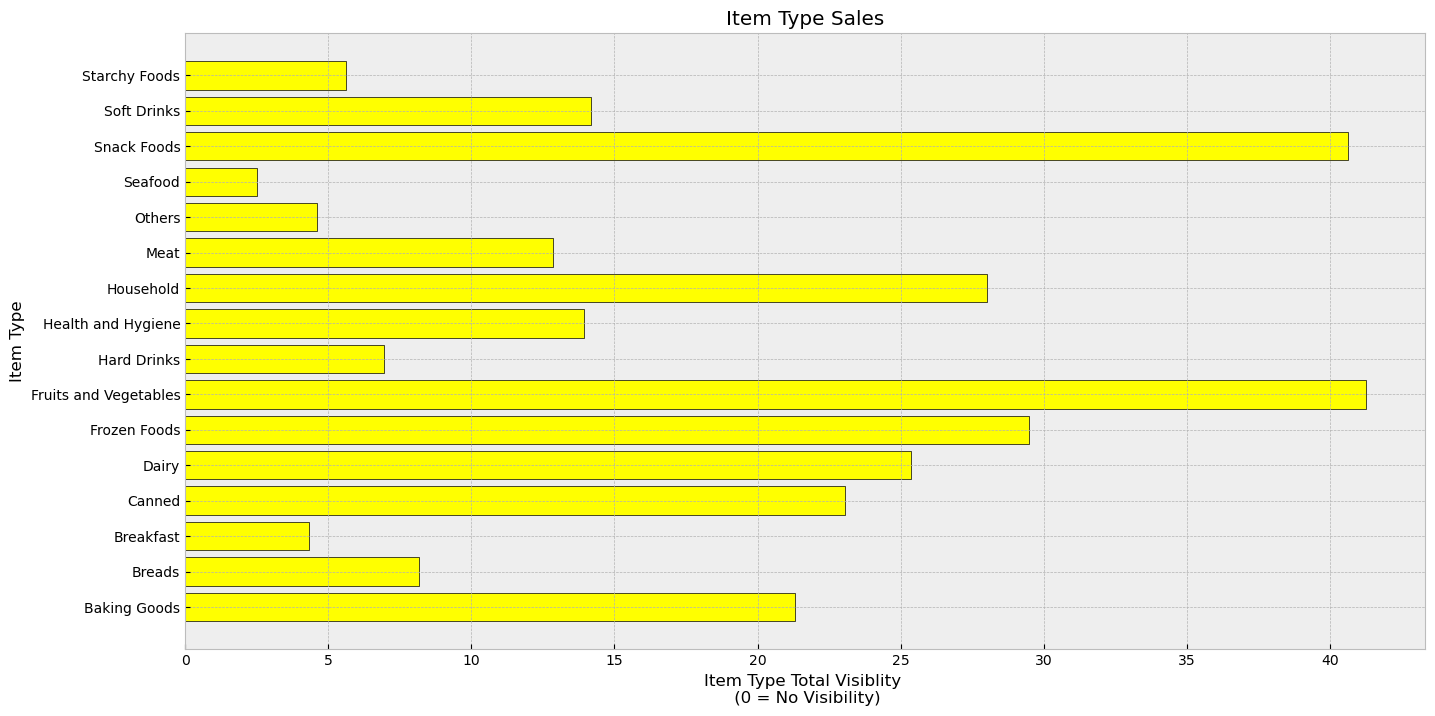

In [41]:
vislist2 = [21.317356289,8.180015266,4.32742859,23.054381197,25.349305827,29.482378354,41.264512,6.964867335,13.938925056,28.012855251,12.83741549,4.600662905,2.510092026,
            40.628863641,14.172282401,5.615876378]

plt.figure(figsize = (16,8))

plt.barh(typelist, vislist2, color = "Yellow", edgecolor = "black");
plt.title("Item Type Sales")
plt.ylabel("Item Type")
plt.xlabel("Item Type Total Visiblity \n (0 = No Visibility)")

[]

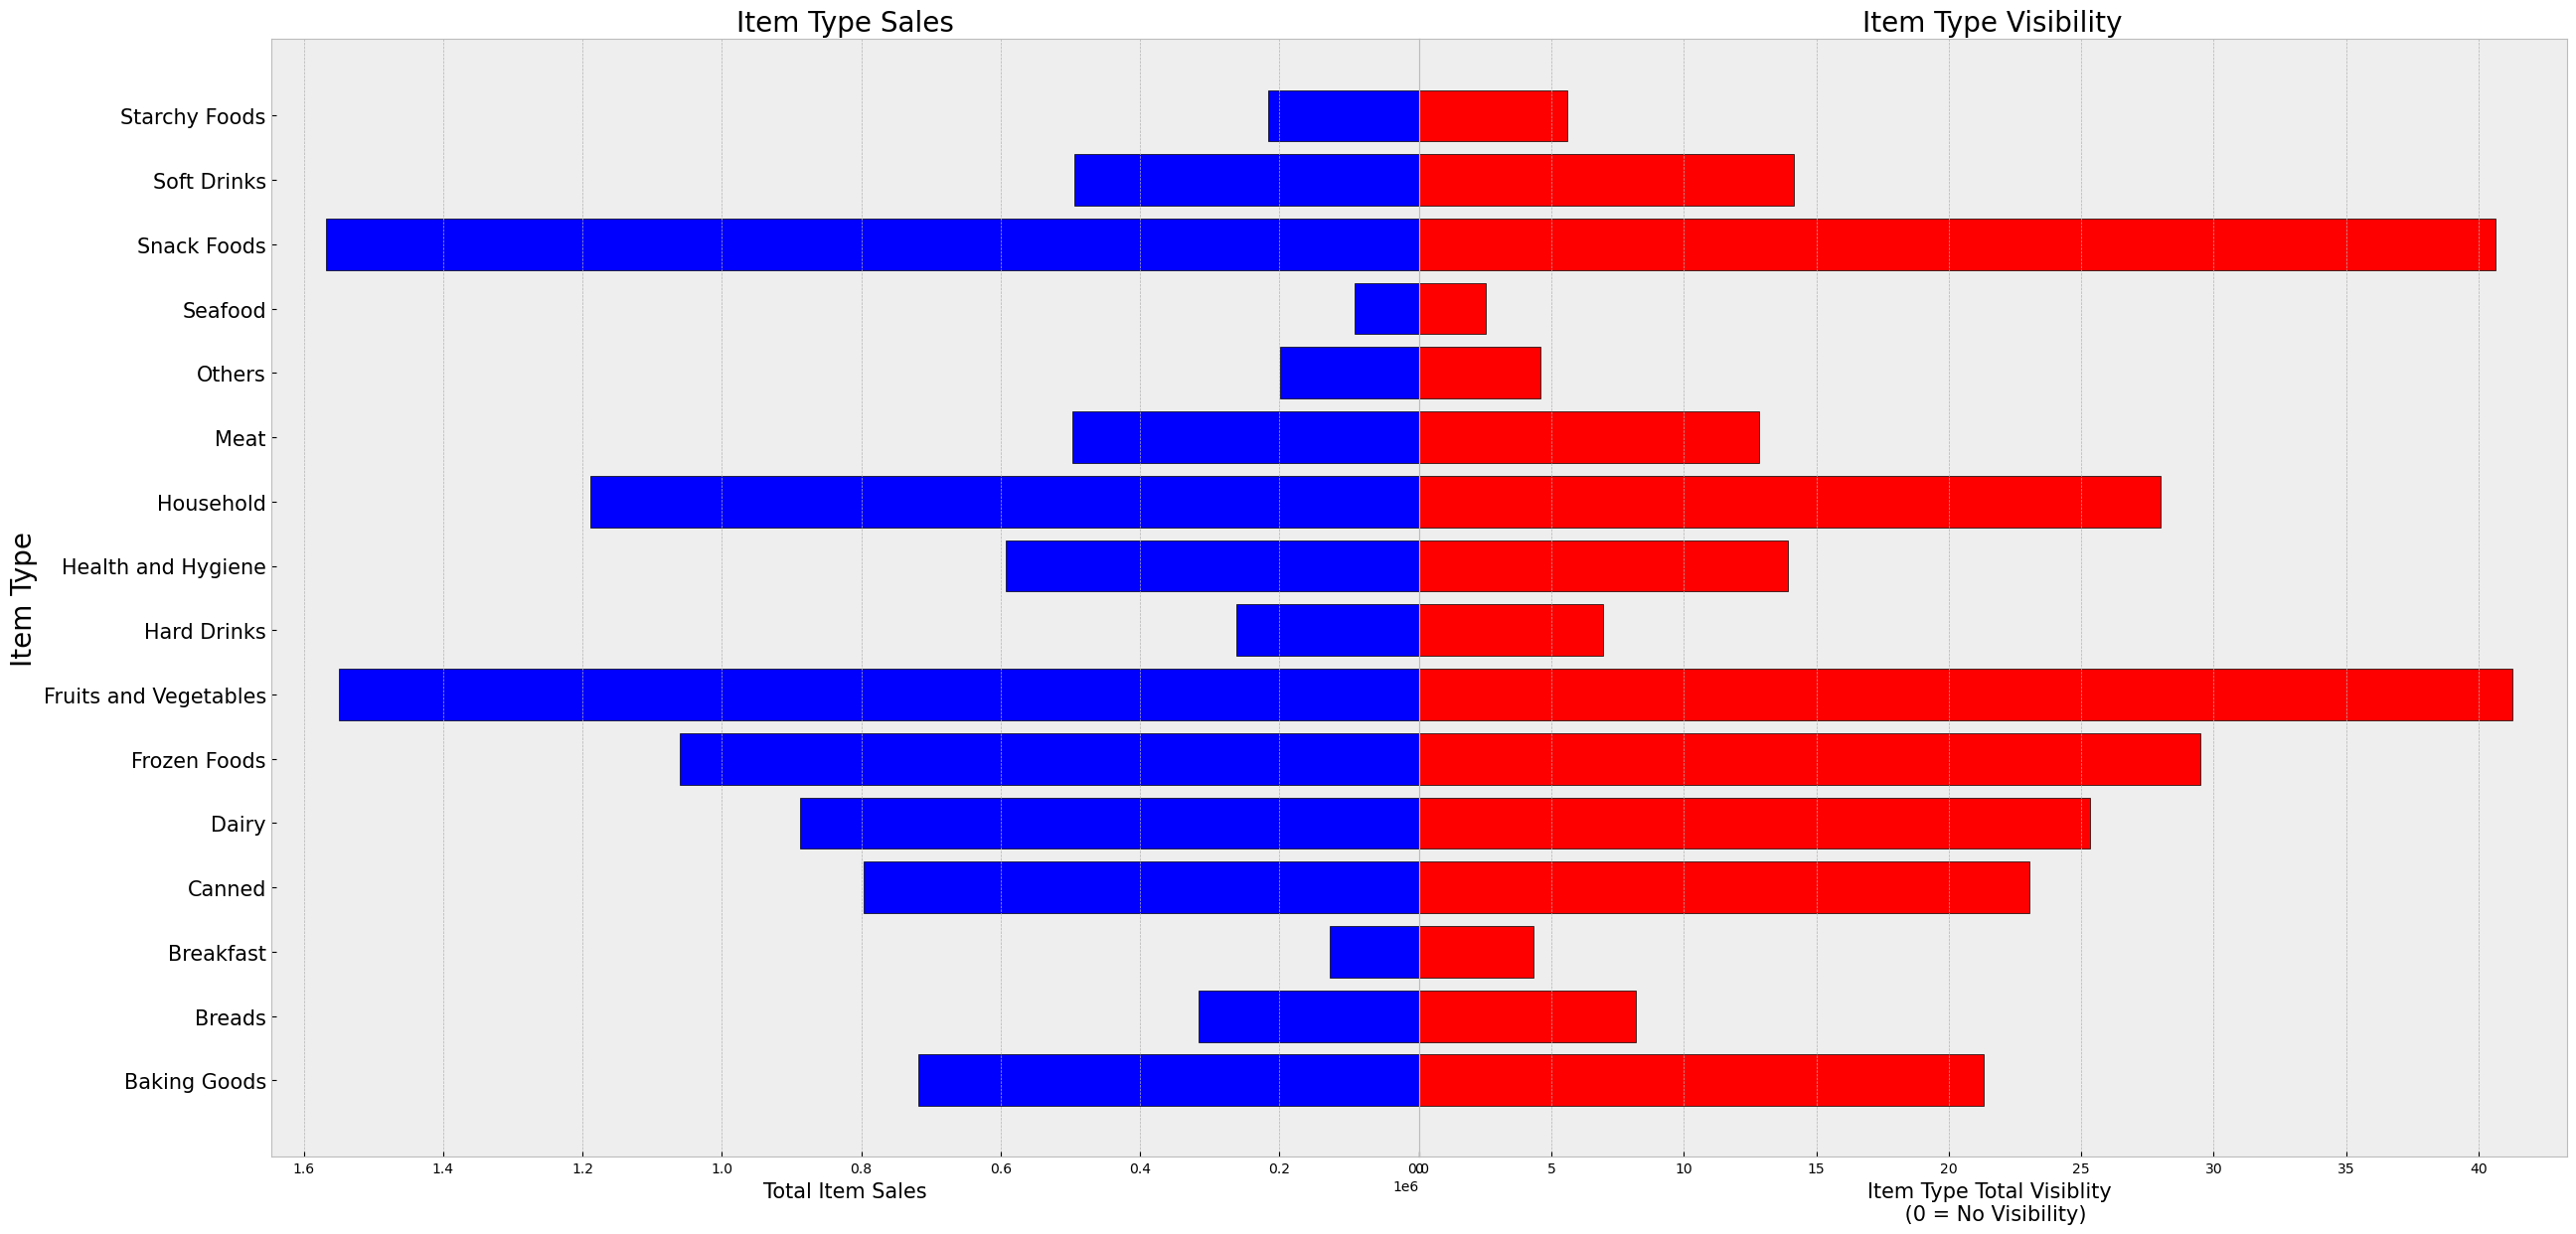

In [42]:
vislist2 = [21.317356289,8.180015266,4.32742859,23.054381197,25.349305827,29.482378354,41.264512,6.964867335,13.938925056,28.012855251,12.83741549,4.600662905,2.510092026,
            40.628863641,14.172282401,5.615876378]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (30,15))
plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)

ax1.barh(typelist, saleslist2, align='center', color = "Blue", edgecolor = "black",)
ax1.set_title("Item Type Sales", fontsize = 20)
ax1.set_ylabel("Item Type", fontsize = 20)
ax1.set_xlabel("Total Item Sales", fontsize = 15)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.invert_xaxis() 
ax1.grid(axis = "y")

ax2.barh(typelist, vislist2, align='center', color = "Red", edgecolor = "black")
ax2.set_title("Item Type Visibility", fontsize = 20)
ax2.set_xlabel("Item Type Total Visiblity \n (0 = No Visibility)", fontsize = 15);
ax2.yaxis.set_tick_params(labelsize=20)
ax2.set_yticks([])

# Task 5

- Before splitting your data, you can drop duplicates and fix inconsistencies in categorical data.* (*There is a way to do this after the split, but for this project, you may perform this step before the split)
- Identify the features (X) and target (y): Assign the "Item_Outlet_Sales" column as your target and the rest of the relevant variables as your features matrix.
- Perform a train test split
- Create a preprocessing object to prepare the dataset for Machine Learning
Make sure your imputation of missing values occurs after the train test split using SimpleImputer.

In [44]:
sales_pred_df2 = pd.read_csv("sales_predictions.csv")

display(sales_pred_df2.head())
sales_pred_df2.info()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Before splitting your data, you can drop duplicates and fix inconsistencies in categorical data.

In [45]:
sales_pred_df2.duplicated().sum()

0

In [46]:
sales_pred_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [47]:
# Fixing inconsistencies
sales_pred_df2["Item_Fat_Content"].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [48]:
sales_pred_df2["Item_Fat_Content"] = sales_pred_df2["Item_Fat_Content"].replace("LF", "Low Fat")
sales_pred_df2["Item_Fat_Content"] = sales_pred_df2["Item_Fat_Content"].replace("low fat", "Low Fat")
sales_pred_df2["Item_Fat_Content"] = sales_pred_df2["Item_Fat_Content"].replace("reg", "Regular")
sales_pred_df2["Item_Fat_Content"].value_counts() # double checking

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## Identify the features (X) and target (y): Assign the "Item_Outlet_Sales" column as your target and the rest of the relevant variables as your features matrix.

In [177]:
# "Item_Outlet_Sales" column is target y.
y = sales_pred_df2["Item_Outlet_Sales"]

X = sales_pred_df2.drop(columns = ["Item_Outlet_Sales"]) # dropping irrelevant columns. 

display(X.head())
X.info()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1
3,FDX07,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store
4,NCD19,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 732.6+ KB


## Perform a train test split

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # 42 for consistency

## Create a preprocessing object to prepare the dataset for Machine Learning

In [179]:
# seperating the numerical and categorical columns 

number_selector = make_column_selector(dtype_include = "number")
category_selector = make_column_selector(dtype_include = "object")

In [180]:
# preprocessing

# Instantiate Scaler for numeral columns
scaler = StandardScaler()

# Instantiate OneHotEncoder for the categorical columns
OHE = OneHotEncoder(handle_unknown = "ignore", sparse = False)

## Make sure your imputation of missing values occurs after the train test split using SimpleImputer.

In [181]:
mean_imputer = SimpleImputer(strategy = "mean") # for numeric columns missing values

In [182]:
frequent_imputer = SimpleImputer(strategy = "most_frequent") # for categorical columns missing values

In [183]:
num_pipe = make_pipeline(mean_imputer, scaler)
cate_pipe = make_pipeline(frequent_imputer, OHE)

num_tuple = (num_pipe, number_selector)
cate_tuple = (cate_pipe, category_selector)

preprocessor = make_column_transformer(num_tuple, cate_tuple, remainder = "passthrough", verbose_feature_names_out = False)

preprocessor # preprocessing object

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002213D00FBB0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer

In [184]:
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP', ...,
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'], dtype=object)

In [185]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,0.82,-0.71,1.83,1.33,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
7510,0.56,-1.29,0.60,1.33,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
5828,-0.13,1.81,0.24,0.14,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
5327,-1.17,-1.00,-0.95,0.73,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
4810,1.53,-0.97,-0.34,0.49,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00


In [186]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,0.33,-0.78,-1.00,-1.29,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
2957,-1.18,0.10,-1.59,-0.10,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
7031,0.38,-0.48,-1.60,0.14,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
1084,0.00,-0.42,0.51,-1.53,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
856,-0.64,-1.05,0.89,0.73,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00


# Final Task 

1. Your first task is to build a linear regression model to predict sales.
  
  - Build a linear regression model.

  - Evaluate the performance of your model based on r^2.

  - Evaluate the performance of your model based on rmse.

2. Your second task is to build a regression tree model to predict sales.

  - Build a simple regression tree model.

  - Compare the performance of your model based on r^2.

  - Compare the performance of your model based on rmse.

3. You now have tried 2 different models on your data set. You need to determine which model to implement.

  - Overall, which model do you recommend?

  - Justify your recommendation.
4. To finalize this project, complete a README in your GitHub repository including:

  - An overview of the project

  - 2 relevant insights from the data (supported with reporting quality visualizations)

  - Summary of the model and its evaluation metrics

  - Final recommendations 


## LinearRegressionModel

In [187]:
# Instantiating the Model

linreg = LinearRegression()

# Model Pipeline

linreg_pipe = make_pipeline(preprocessor, linreg)

# Fitting the data

linreg_pipe.fit(X_train_df, y_train)
evaluate_regression(linreg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= -11117605550099450975748096.00	RMSE= 5736031830971473.00
Test Data:	R^2= -12058110731763349167538176.00	RMSE= 5767846534261531.00


C:\Users\spart\anaconda3\envs\dojo-env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\spart\anaconda3\envs\dojo-env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [188]:
linreg.coef_

array([ 7.97949861e+00, -3.17178556e+01, -6.76445535e+02, ...,
       -3.89136474e+15, -1.59409483e+15, -1.45331817e+15])

In [193]:
## Saving the coefficients
coeffs = pd.Series(linreg.coef_, index= feature_names)
coeffs.loc['intercept'] = linreg.intercept_
coeffs

Item_Weight                                          7.98
Item_Visibility                                    -31.72
Item_MRP                                          -676.45
Outlet_Establishment_Year         -365,238,205,469,061.75
Item_Identifier_DRA12               75,500,999,785,676.25
                                           ...           
Outlet_Type_Grocery Store       -1,979,917,249,640,706.25
Outlet_Type_Supermarket Type1   -3,891,364,743,326,407.50
Outlet_Type_Supermarket Type2   -1,594,094,834,111,723.25
Outlet_Type_Supermarket Type3   -1,453,318,168,656,766.50
intercept                                        2,227.98
Length: 1593, dtype: float64

In [212]:
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
coeff_rank

Item_Type_Breads                1,593.00
Outlet_Type_Supermarket Type1   1,592.00
Item_Type_Hard Drinks           1,591.00
Item_Type_Breakfast             1,590.00
Item_Type_Snack Foods           1,589.00
                                  ...   
Item_Identifier_FDQ44               5.00
intercept                           4.00
Item_MRP                            3.00
Item_Visibility                     2.00
Item_Weight                         1.00
Length: 1593, dtype: float64

In [213]:
top_n_features = coeff_rank.head(3)
top_n_features

Item_Type_Breads                1,593.00
Outlet_Type_Supermarket Type1   1,592.00
Item_Type_Hard Drinks           1,591.00
dtype: float64

In [211]:
## Slicing out the top_n_features names to visualize
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
plot_vals = coeffs.loc[top_n_features.index]
plot_vals

Item_Type_Breads                -4,025,262,269,625,587.00
Outlet_Type_Supermarket Type1   -3,891,364,743,326,407.50
Item_Type_Hard Drinks           -3,376,725,488,835,020.00
dtype: float64

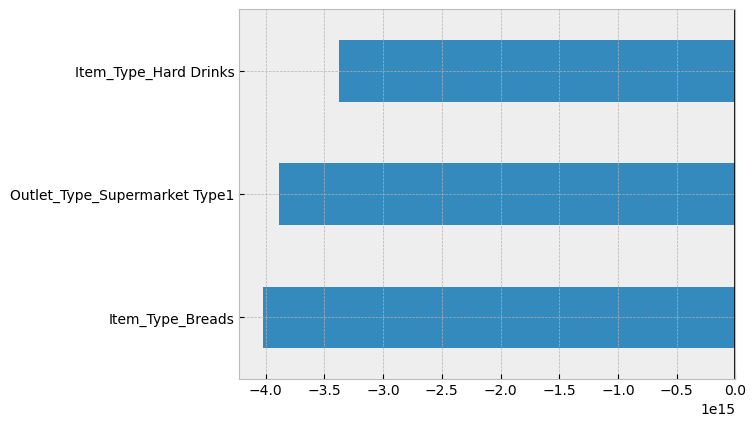

In [204]:
ax = plot_vals.sort_values().plot(kind='barh')#,figsize=(5,6))
ax.axvline(0,color='k')

In [192]:
# Model Predictions 

train_prediction = linreg_pipe.predict(X_train)
test_prediction = linreg_pipe.predict(X_test)

KeyError: "['Item_Identifier_DRA12', 'Item_Identifier_DRA24', 'Item_Identifier_DRA59', 'Item_Identifier_DRB01', 'Item_Identifier_DRB13', 'Item_Identifier_DRB24', 'Item_Identifier_DRB25', 'Item_Identifier_DRB48', 'Item_Identifier_DRC01', 'Item_Identifier_DRC12', 'Item_Identifier_DRC13', 'Item_Identifier_DRC25', 'Item_Identifier_DRC27', 'Item_Identifier_DRC36', 'Item_Identifier_DRC49', 'Item_Identifier_DRD01', 'Item_Identifier_DRD12', 'Item_Identifier_DRD13', 'Item_Identifier_DRD15', 'Item_Identifier_DRD24', 'Item_Identifier_DRD25', 'Item_Identifier_DRD27', 'Item_Identifier_DRD37', 'Item_Identifier_DRD49', 'Item_Identifier_DRD60', 'Item_Identifier_DRE01', 'Item_Identifier_DRE03', 'Item_Identifier_DRE12', 'Item_Identifier_DRE13', 'Item_Identifier_DRE15', 'Item_Identifier_DRE25', 'Item_Identifier_DRE27', 'Item_Identifier_DRE37', 'Item_Identifier_DRE48', 'Item_Identifier_DRE49', 'Item_Identifier_DRE60', 'Item_Identifier_DRF01', 'Item_Identifier_DRF03', 'Item_Identifier_DRF13', 'Item_Identifier_DRF15', 'Item_Identifier_DRF23', 'Item_Identifier_DRF25', 'Item_Identifier_DRF27', 'Item_Identifier_DRF36', 'Item_Identifier_DRF37', 'Item_Identifier_DRF48', 'Item_Identifier_DRF49', 'Item_Identifier_DRF51', 'Item_Identifier_DRF60', 'Item_Identifier_DRG01', 'Item_Identifier_DRG03', 'Item_Identifier_DRG11', 'Item_Identifier_DRG13', 'Item_Identifier_DRG15', 'Item_Identifier_DRG23', 'Item_Identifier_DRG25', 'Item_Identifier_DRG27', 'Item_Identifier_DRG36', 'Item_Identifier_DRG37', 'Item_Identifier_DRG39', 'Item_Identifier_DRG48', 'Item_Identifier_DRG49', 'Item_Identifier_DRG51', 'Item_Identifier_DRH01', 'Item_Identifier_DRH03', 'Item_Identifier_DRH11', 'Item_Identifier_DRH13', 'Item_Identifier_DRH15', 'Item_Identifier_DRH23', 'Item_Identifier_DRH25', 'Item_Identifier_DRH36', 'Item_Identifier_DRH37', 'Item_Identifier_DRH39', 'Item_Identifier_DRH49', 'Item_Identifier_DRH51', 'Item_Identifier_DRH59', 'Item_Identifier_DRI01', 'Item_Identifier_DRI03', 'Item_Identifier_DRI11', 'Item_Identifier_DRI13', 'Item_Identifier_DRI23', 'Item_Identifier_DRI25', 'Item_Identifier_DRI37', 'Item_Identifier_DRI39', 'Item_Identifier_DRI47', 'Item_Identifier_DRI49', 'Item_Identifier_DRI51', 'Item_Identifier_DRI59', 'Item_Identifier_DRJ01', 'Item_Identifier_DRJ11', 'Item_Identifier_DRJ13', 'Item_Identifier_DRJ23', 'Item_Identifier_DRJ24', 'Item_Identifier_DRJ25', 'Item_Identifier_DRJ35', 'Item_Identifier_DRJ37', 'Item_Identifier_DRJ39', 'Item_Identifier_DRJ47', 'Item_Identifier_DRJ49', 'Item_Identifier_DRJ51', 'Item_Identifier_DRJ59', 'Item_Identifier_DRK01', 'Item_Identifier_DRK11', 'Item_Identifier_DRK12', 'Item_Identifier_DRK13', 'Item_Identifier_DRK23', 'Item_Identifier_DRK35', 'Item_Identifier_DRK37', 'Item_Identifier_DRK39', 'Item_Identifier_DRK47', 'Item_Identifier_DRK49', 'Item_Identifier_DRK59', 'Item_Identifier_DRL01', 'Item_Identifier_DRL11', 'Item_Identifier_DRL23', 'Item_Identifier_DRL35', 'Item_Identifier_DRL37', 'Item_Identifier_DRL47', 'Item_Identifier_DRL49', 'Item_Identifier_DRL59', 'Item_Identifier_DRL60', 'Item_Identifier_DRM11', 'Item_Identifier_DRM23', 'Item_Identifier_DRM35', 'Item_Identifier_DRM37', 'Item_Identifier_DRM47', 'Item_Identifier_DRM48', 'Item_Identifier_DRM49', 'Item_Identifier_DRM59', 'Item_Identifier_DRN11', 'Item_Identifier_DRN35', 'Item_Identifier_DRN36', 'Item_Identifier_DRN37', 'Item_Identifier_DRN47', 'Item_Identifier_DRN59', 'Item_Identifier_DRO35', 'Item_Identifier_DRO47', 'Item_Identifier_DRO59', 'Item_Identifier_DRP35', 'Item_Identifier_DRP47', 'Item_Identifier_DRQ35', 'Item_Identifier_DRY23', 'Item_Identifier_DRZ11', 'Item_Identifier_DRZ24', 'Item_Identifier_FDA01', 'Item_Identifier_FDA02', 'Item_Identifier_FDA03', 'Item_Identifier_FDA04', 'Item_Identifier_FDA07', 'Item_Identifier_FDA08', 'Item_Identifier_FDA09', 'Item_Identifier_FDA10', 'Item_Identifier_FDA11', 'Item_Identifier_FDA13', 'Item_Identifier_FDA14', 'Item_Identifier_FDA15', 'Item_Identifier_FDA16', 'Item_Identifier_FDA19', 'Item_Identifier_FDA20', 'Item_Identifier_FDA21', 'Item_Identifier_FDA22', 'Item_Identifier_FDA23', 'Item_Identifier_FDA25', 'Item_Identifier_FDA26', 'Item_Identifier_FDA27', 'Item_Identifier_FDA28', 'Item_Identifier_FDA31', 'Item_Identifier_FDA32', 'Item_Identifier_FDA33', 'Item_Identifier_FDA34', 'Item_Identifier_FDA35', 'Item_Identifier_FDA36', 'Item_Identifier_FDA37', 'Item_Identifier_FDA38', 'Item_Identifier_FDA39', 'Item_Identifier_FDA40', 'Item_Identifier_FDA43', 'Item_Identifier_FDA44', 'Item_Identifier_FDA45', 'Item_Identifier_FDA46', 'Item_Identifier_FDA47', 'Item_Identifier_FDA48', 'Item_Identifier_FDA49', 'Item_Identifier_FDA50', 'Item_Identifier_FDA51', 'Item_Identifier_FDA52', 'Item_Identifier_FDA55', 'Item_Identifier_FDA56', 'Item_Identifier_FDA57', 'Item_Identifier_FDA58', 'Item_Identifier_FDB02', 'Item_Identifier_FDB03', 'Item_Identifier_FDB04', 'Item_Identifier_FDB05', 'Item_Identifier_FDB08', 'Item_Identifier_FDB09', 'Item_Identifier_FDB10', 'Item_Identifier_FDB11', 'Item_Identifier_FDB12', 'Item_Identifier_FDB14', 'Item_Identifier_FDB15', 'Item_Identifier_FDB16', 'Item_Identifier_FDB17', 'Item_Identifier_FDB20', 'Item_Identifier_FDB21', 'Item_Identifier_FDB22', 'Item_Identifier_FDB23', 'Item_Identifier_FDB26', 'Item_Identifier_FDB27', 'Item_Identifier_FDB28', 'Item_Identifier_FDB29', 'Item_Identifier_FDB32', 'Item_Identifier_FDB33', 'Item_Identifier_FDB34', 'Item_Identifier_FDB35', 'Item_Identifier_FDB36', 'Item_Identifier_FDB37', 'Item_Identifier_FDB38', 'Item_Identifier_FDB39', 'Item_Identifier_FDB40', 'Item_Identifier_FDB41', 'Item_Identifier_FDB44', 'Item_Identifier_FDB45', 'Item_Identifier_FDB46', 'Item_Identifier_FDB47', 'Item_Identifier_FDB49', 'Item_Identifier_FDB50', 'Item_Identifier_FDB51', 'Item_Identifier_FDB52', 'Item_Identifier_FDB53', 'Item_Identifier_FDB56', 'Item_Identifier_FDB57', 'Item_Identifier_FDB58', 'Item_Identifier_FDB59', 'Item_Identifier_FDB60', 'Item_Identifier_FDC02', 'Item_Identifier_FDC03', 'Item_Identifier_FDC04', 'Item_Identifier_FDC05', 'Item_Identifier_FDC08', 'Item_Identifier_FDC09', 'Item_Identifier_FDC10', 'Item_Identifier_FDC11', 'Item_Identifier_FDC14', 'Item_Identifier_FDC15', 'Item_Identifier_FDC16', 'Item_Identifier_FDC17', 'Item_Identifier_FDC20', 'Item_Identifier_FDC21', 'Item_Identifier_FDC22', 'Item_Identifier_FDC26', 'Item_Identifier_FDC29', 'Item_Identifier_FDC32', 'Item_Identifier_FDC33', 'Item_Identifier_FDC34', 'Item_Identifier_FDC35', 'Item_Identifier_FDC37', 'Item_Identifier_FDC38', 'Item_Identifier_FDC39', 'Item_Identifier_FDC40', 'Item_Identifier_FDC41', 'Item_Identifier_FDC44', 'Item_Identifier_FDC45', 'Item_Identifier_FDC46', 'Item_Identifier_FDC47', 'Item_Identifier_FDC48', 'Item_Identifier_FDC50', 'Item_Identifier_FDC51', 'Item_Identifier_FDC52', 'Item_Identifier_FDC53', 'Item_Identifier_FDC56', 'Item_Identifier_FDC57', 'Item_Identifier_FDC58', 'Item_Identifier_FDC59', 'Item_Identifier_FDC60', 'Item_Identifier_FDD02', 'Item_Identifier_FDD03', 'Item_Identifier_FDD04', 'Item_Identifier_FDD05', 'Item_Identifier_FDD08', 'Item_Identifier_FDD09', 'Item_Identifier_FDD10', 'Item_Identifier_FDD11', 'Item_Identifier_FDD14', 'Item_Identifier_FDD16', 'Item_Identifier_FDD17', 'Item_Identifier_FDD20', 'Item_Identifier_FDD21', 'Item_Identifier_FDD22', 'Item_Identifier_FDD23', 'Item_Identifier_FDD26', 'Item_Identifier_FDD28', 'Item_Identifier_FDD29', 'Item_Identifier_FDD32', 'Item_Identifier_FDD33', 'Item_Identifier_FDD34', 'Item_Identifier_FDD35', 'Item_Identifier_FDD36', 'Item_Identifier_FDD38', 'Item_Identifier_FDD39', 'Item_Identifier_FDD40', 'Item_Identifier_FDD41', 'Item_Identifier_FDD44', 'Item_Identifier_FDD45', 'Item_Identifier_FDD46', 'Item_Identifier_FDD47', 'Item_Identifier_FDD48', 'Item_Identifier_FDD50', 'Item_Identifier_FDD51', 'Item_Identifier_FDD52', 'Item_Identifier_FDD53', 'Item_Identifier_FDD56', 'Item_Identifier_FDD57', 'Item_Identifier_FDD58', 'Item_Identifier_FDD59', 'Item_Identifier_FDE02', 'Item_Identifier_FDE04', 'Item_Identifier_FDE05', 'Item_Identifier_FDE08', 'Item_Identifier_FDE09', 'Item_Identifier_FDE10', 'Item_Identifier_FDE11', 'Item_Identifier_FDE14', 'Item_Identifier_FDE16', 'Item_Identifier_FDE17', 'Item_Identifier_FDE20', 'Item_Identifier_FDE21', 'Item_Identifier_FDE22', 'Item_Identifier_FDE23', 'Item_Identifier_FDE24', 'Item_Identifier_FDE26', 'Item_Identifier_FDE28', 'Item_Identifier_FDE29', 'Item_Identifier_FDE32', 'Item_Identifier_FDE33', 'Item_Identifier_FDE34', 'Item_Identifier_FDE35', 'Item_Identifier_FDE36', 'Item_Identifier_FDE38', 'Item_Identifier_FDE39', 'Item_Identifier_FDE40', 'Item_Identifier_FDE41', 'Item_Identifier_FDE44', 'Item_Identifier_FDE45', 'Item_Identifier_FDE46', 'Item_Identifier_FDE47', 'Item_Identifier_FDE50', 'Item_Identifier_FDE51', 'Item_Identifier_FDE52', 'Item_Identifier_FDE53', 'Item_Identifier_FDE56', 'Item_Identifier_FDE57', 'Item_Identifier_FDE58', 'Item_Identifier_FDE59', 'Item_Identifier_FDF02', 'Item_Identifier_FDF04', 'Item_Identifier_FDF05', 'Item_Identifier_FDF08', 'Item_Identifier_FDF09', 'Item_Identifier_FDF10', 'Item_Identifier_FDF11', 'Item_Identifier_FDF12', 'Item_Identifier_FDF14', 'Item_Identifier_FDF16', 'Item_Identifier_FDF17', 'Item_Identifier_FDF20', 'Item_Identifier_FDF21', 'Item_Identifier_FDF22', 'Item_Identifier_FDF24', 'Item_Identifier_FDF26', 'Item_Identifier_FDF28', 'Item_Identifier_FDF29', 'Item_Identifier_FDF32', 'Item_Identifier_FDF33', 'Item_Identifier_FDF34', 'Item_Identifier_FDF35', 'Item_Identifier_FDF38', 'Item_Identifier_FDF39', 'Item_Identifier_FDF40', 'Item_Identifier_FDF41', 'Item_Identifier_FDF44', 'Item_Identifier_FDF45', 'Item_Identifier_FDF46', 'Item_Identifier_FDF47', 'Item_Identifier_FDF50', 'Item_Identifier_FDF52', 'Item_Identifier_FDF53', 'Item_Identifier_FDF56', 'Item_Identifier_FDF57', 'Item_Identifier_FDF58', 'Item_Identifier_FDF59', 'Item_Identifier_FDG02', 'Item_Identifier_FDG04', 'Item_Identifier_FDG05', 'Item_Identifier_FDG08', 'Item_Identifier_FDG09', 'Item_Identifier_FDG10', 'Item_Identifier_FDG12', 'Item_Identifier_FDG14', 'Item_Identifier_FDG16', 'Item_Identifier_FDG17', 'Item_Identifier_FDG20', 'Item_Identifier_FDG21', 'Item_Identifier_FDG22', 'Item_Identifier_FDG24', 'Item_Identifier_FDG26', 'Item_Identifier_FDG28', 'Item_Identifier_FDG29', 'Item_Identifier_FDG31', 'Item_Identifier_FDG32', 'Item_Identifier_FDG33', 'Item_Identifier_FDG34', 'Item_Identifier_FDG35', 'Item_Identifier_FDG38', 'Item_Identifier_FDG40', 'Item_Identifier_FDG41', 'Item_Identifier_FDG44', 'Item_Identifier_FDG45', 'Item_Identifier_FDG46', 'Item_Identifier_FDG47', 'Item_Identifier_FDG50', 'Item_Identifier_FDG52', 'Item_Identifier_FDG53', 'Item_Identifier_FDG56', 'Item_Identifier_FDG57', 'Item_Identifier_FDG58', 'Item_Identifier_FDG59', 'Item_Identifier_FDG60', 'Item_Identifier_FDH02', 'Item_Identifier_FDH04', 'Item_Identifier_FDH05', 'Item_Identifier_FDH08', 'Item_Identifier_FDH09', 'Item_Identifier_FDH10', 'Item_Identifier_FDH12', 'Item_Identifier_FDH14', 'Item_Identifier_FDH16', 'Item_Identifier_FDH17', 'Item_Identifier_FDH19', 'Item_Identifier_FDH20', 'Item_Identifier_FDH21', 'Item_Identifier_FDH22', 'Item_Identifier_FDH24', 'Item_Identifier_FDH26', 'Item_Identifier_FDH27', 'Item_Identifier_FDH28', 'Item_Identifier_FDH31', 'Item_Identifier_FDH32', 'Item_Identifier_FDH33', 'Item_Identifier_FDH34', 'Item_Identifier_FDH35', 'Item_Identifier_FDH38', 'Item_Identifier_FDH40', 'Item_Identifier_FDH41', 'Item_Identifier_FDH44', 'Item_Identifier_FDH45', 'Item_Identifier_FDH46', 'Item_Identifier_FDH47', 'Item_Identifier_FDH48', 'Item_Identifier_FDH50', 'Item_Identifier_FDH52', 'Item_Identifier_FDH53', 'Item_Identifier_FDH56', 'Item_Identifier_FDH57', 'Item_Identifier_FDH58', 'Item_Identifier_FDH60', 'Item_Identifier_FDI02', 'Item_Identifier_FDI04', 'Item_Identifier_FDI05', 'Item_Identifier_FDI07', 'Item_Identifier_FDI08', 'Item_Identifier_FDI09', 'Item_Identifier_FDI10', 'Item_Identifier_FDI12', 'Item_Identifier_FDI14', 'Item_Identifier_FDI15', 'Item_Identifier_FDI16', 'Item_Identifier_FDI19', 'Item_Identifier_FDI20', 'Item_Identifier_FDI21', 'Item_Identifier_FDI22', 'Item_Identifier_FDI24', 'Item_Identifier_FDI26', 'Item_Identifier_FDI27', 'Item_Identifier_FDI28', 'Item_Identifier_FDI32', 'Item_Identifier_FDI33', 'Item_Identifier_FDI34', 'Item_Identifier_FDI35', 'Item_Identifier_FDI36', 'Item_Identifier_FDI38', 'Item_Identifier_FDI40', 'Item_Identifier_FDI41', 'Item_Identifier_FDI44', 'Item_Identifier_FDI45', 'Item_Identifier_FDI46', 'Item_Identifier_FDI48', 'Item_Identifier_FDI50', 'Item_Identifier_FDI52', 'Item_Identifier_FDI53', 'Item_Identifier_FDI56', 'Item_Identifier_FDI57', 'Item_Identifier_FDI58', 'Item_Identifier_FDI60', 'Item_Identifier_FDJ02', 'Item_Identifier_FDJ03', 'Item_Identifier_FDJ04', 'Item_Identifier_FDJ07', 'Item_Identifier_FDJ08', 'Item_Identifier_FDJ09', 'Item_Identifier_FDJ10', 'Item_Identifier_FDJ12', 'Item_Identifier_FDJ14', 'Item_Identifier_FDJ15', 'Item_Identifier_FDJ16', 'Item_Identifier_FDJ20', 'Item_Identifier_FDJ21', 'Item_Identifier_FDJ22', 'Item_Identifier_FDJ26', 'Item_Identifier_FDJ27', 'Item_Identifier_FDJ28', 'Item_Identifier_FDJ32', 'Item_Identifier_FDJ33', 'Item_Identifier_FDJ34', 'Item_Identifier_FDJ36', 'Item_Identifier_FDJ38', 'Item_Identifier_FDJ40', 'Item_Identifier_FDJ41', 'Item_Identifier_FDJ44', 'Item_Identifier_FDJ45', 'Item_Identifier_FDJ46', 'Item_Identifier_FDJ48', 'Item_Identifier_FDJ50', 'Item_Identifier_FDJ52', 'Item_Identifier_FDJ53', 'Item_Identifier_FDJ55', 'Item_Identifier_FDJ56', 'Item_Identifier_FDJ57', 'Item_Identifier_FDJ58', 'Item_Identifier_FDJ60', 'Item_Identifier_FDK02', 'Item_Identifier_FDK03', 'Item_Identifier_FDK04', 'Item_Identifier_FDK08', 'Item_Identifier_FDK09', 'Item_Identifier_FDK10', 'Item_Identifier_FDK14', 'Item_Identifier_FDK15', 'Item_Identifier_FDK16', 'Item_Identifier_FDK20', 'Item_Identifier_FDK21', 'Item_Identifier_FDK22', 'Item_Identifier_FDK24', 'Item_Identifier_FDK25', 'Item_Identifier_FDK26', 'Item_Identifier_FDK27', 'Item_Identifier_FDK28', 'Item_Identifier_FDK32', 'Item_Identifier_FDK33', 'Item_Identifier_FDK34', 'Item_Identifier_FDK36', 'Item_Identifier_FDK38', 'Item_Identifier_FDK40', 'Item_Identifier_FDK41', 'Item_Identifier_FDK43', 'Item_Identifier_FDK44', 'Item_Identifier_FDK45', 'Item_Identifier_FDK46', 'Item_Identifier_FDK48', 'Item_Identifier_FDK50', 'Item_Identifier_FDK51', 'Item_Identifier_FDK52', 'Item_Identifier_FDK55', 'Item_Identifier_FDK56', 'Item_Identifier_FDK58', 'Item_Identifier_FDK60', 'Item_Identifier_FDL02', 'Item_Identifier_FDL03', 'Item_Identifier_FDL04', 'Item_Identifier_FDL08', 'Item_Identifier_FDL09', 'Item_Identifier_FDL10', 'Item_Identifier_FDL12', 'Item_Identifier_FDL13', 'Item_Identifier_FDL14', 'Item_Identifier_FDL15', 'Item_Identifier_FDL16', 'Item_Identifier_FDL20', 'Item_Identifier_FDL21', 'Item_Identifier_FDL22', 'Item_Identifier_FDL24', 'Item_Identifier_FDL25', 'Item_Identifier_FDL26', 'Item_Identifier_FDL27', 'Item_Identifier_FDL28', 'Item_Identifier_FDL32', 'Item_Identifier_FDL33', 'Item_Identifier_FDL34', 'Item_Identifier_FDL36', 'Item_Identifier_FDL38', 'Item_Identifier_FDL39', 'Item_Identifier_FDL40', 'Item_Identifier_FDL43', 'Item_Identifier_FDL44', 'Item_Identifier_FDL45', 'Item_Identifier_FDL46', 'Item_Identifier_FDL48', 'Item_Identifier_FDL50', 'Item_Identifier_FDL51', 'Item_Identifier_FDL52', 'Item_Identifier_FDL56', 'Item_Identifier_FDL57', 'Item_Identifier_FDL58', 'Item_Identifier_FDM01', 'Item_Identifier_FDM02', 'Item_Identifier_FDM03', 'Item_Identifier_FDM04', 'Item_Identifier_FDM08', 'Item_Identifier_FDM09', 'Item_Identifier_FDM10', 'Item_Identifier_FDM12', 'Item_Identifier_FDM13', 'Item_Identifier_FDM14', 'Item_Identifier_FDM15', 'Item_Identifier_FDM20', 'Item_Identifier_FDM21', 'Item_Identifier_FDM22', 'Item_Identifier_FDM24', 'Item_Identifier_FDM25', 'Item_Identifier_FDM27', 'Item_Identifier_FDM28', 'Item_Identifier_FDM32', 'Item_Identifier_FDM33', 'Item_Identifier_FDM34', 'Item_Identifier_FDM36', 'Item_Identifier_FDM38', 'Item_Identifier_FDM39', 'Item_Identifier_FDM40', 'Item_Identifier_FDM44', 'Item_Identifier_FDM45', 'Item_Identifier_FDM46', 'Item_Identifier_FDM50', 'Item_Identifier_FDM51', 'Item_Identifier_FDM52', 'Item_Identifier_FDM56', 'Item_Identifier_FDM57', 'Item_Identifier_FDM58', 'Item_Identifier_FDM60', 'Item_Identifier_FDN01', 'Item_Identifier_FDN02', 'Item_Identifier_FDN03', 'Item_Identifier_FDN04', 'Item_Identifier_FDN08', 'Item_Identifier_FDN09', 'Item_Identifier_FDN10', 'Item_Identifier_FDN12', 'Item_Identifier_FDN13', 'Item_Identifier_FDN15', 'Item_Identifier_FDN16', 'Item_Identifier_FDN20', 'Item_Identifier_FDN21', 'Item_Identifier_FDN22', 'Item_Identifier_FDN23', 'Item_Identifier_FDN24', 'Item_Identifier_FDN25', 'Item_Identifier_FDN27', 'Item_Identifier_FDN28', 'Item_Identifier_FDN31', 'Item_Identifier_FDN32', 'Item_Identifier_FDN33', 'Item_Identifier_FDN34', 'Item_Identifier_FDN38', 'Item_Identifier_FDN39', 'Item_Identifier_FDN40', 'Item_Identifier_FDN44', 'Item_Identifier_FDN45', 'Item_Identifier_FDN46', 'Item_Identifier_FDN48', 'Item_Identifier_FDN49', 'Item_Identifier_FDN50', 'Item_Identifier_FDN51', 'Item_Identifier_FDN56', 'Item_Identifier_FDN57', 'Item_Identifier_FDN58', 'Item_Identifier_FDN60', 'Item_Identifier_FDO01', 'Item_Identifier_FDO03', 'Item_Identifier_FDO04', 'Item_Identifier_FDO08', 'Item_Identifier_FDO09', 'Item_Identifier_FDO10', 'Item_Identifier_FDO11', 'Item_Identifier_FDO12', 'Item_Identifier_FDO13', 'Item_Identifier_FDO15', 'Item_Identifier_FDO16', 'Item_Identifier_FDO19', 'Item_Identifier_FDO20', 'Item_Identifier_FDO21', 'Item_Identifier_FDO22', 'Item_Identifier_FDO23', 'Item_Identifier_FDO24', 'Item_Identifier_FDO25', 'Item_Identifier_FDO27', 'Item_Identifier_FDO28', 'Item_Identifier_FDO31', 'Item_Identifier_FDO32', 'Item_Identifier_FDO33', 'Item_Identifier_FDO34', 'Item_Identifier_FDO36', 'Item_Identifier_FDO37', 'Item_Identifier_FDO38', 'Item_Identifier_FDO39', 'Item_Identifier_FDO40', 'Item_Identifier_FDO44', 'Item_Identifier_FDO45', 'Item_Identifier_FDO46', 'Item_Identifier_FDO48', 'Item_Identifier_FDO49', 'Item_Identifier_FDO50', 'Item_Identifier_FDO51', 'Item_Identifier_FDO52', 'Item_Identifier_FDO56', 'Item_Identifier_FDO57', 'Item_Identifier_FDO58', 'Item_Identifier_FDO60', 'Item_Identifier_FDP01', 'Item_Identifier_FDP03', 'Item_Identifier_FDP04', 'Item_Identifier_FDP07', 'Item_Identifier_FDP08', 'Item_Identifier_FDP09', 'Item_Identifier_FDP10', 'Item_Identifier_FDP11', 'Item_Identifier_FDP12', 'Item_Identifier_FDP13', 'Item_Identifier_FDP15', 'Item_Identifier_FDP16', 'Item_Identifier_FDP19', 'Item_Identifier_FDP20', 'Item_Identifier_FDP21', 'Item_Identifier_FDP22', 'Item_Identifier_FDP23', 'Item_Identifier_FDP24', 'Item_Identifier_FDP25', 'Item_Identifier_FDP26', 'Item_Identifier_FDP27', 'Item_Identifier_FDP28', 'Item_Identifier_FDP31', 'Item_Identifier_FDP32', 'Item_Identifier_FDP33', 'Item_Identifier_FDP34', 'Item_Identifier_FDP36', 'Item_Identifier_FDP37', 'Item_Identifier_FDP38', 'Item_Identifier_FDP39', 'Item_Identifier_FDP40', 'Item_Identifier_FDP44', 'Item_Identifier_FDP45', 'Item_Identifier_FDP46', 'Item_Identifier_FDP48', 'Item_Identifier_FDP49', 'Item_Identifier_FDP51', 'Item_Identifier_FDP52', 'Item_Identifier_FDP56', 'Item_Identifier_FDP57', 'Item_Identifier_FDP58', 'Item_Identifier_FDP59', 'Item_Identifier_FDP60', 'Item_Identifier_FDQ01', 'Item_Identifier_FDQ03', 'Item_Identifier_FDQ04', 'Item_Identifier_FDQ07', 'Item_Identifier_FDQ08', 'Item_Identifier_FDQ09', 'Item_Identifier_FDQ10', 'Item_Identifier_FDQ11', 'Item_Identifier_FDQ12', 'Item_Identifier_FDQ13', 'Item_Identifier_FDQ14', 'Item_Identifier_FDQ15', 'Item_Identifier_FDQ16', 'Item_Identifier_FDQ19', 'Item_Identifier_FDQ20', 'Item_Identifier_FDQ21', 'Item_Identifier_FDQ22', 'Item_Identifier_FDQ23', 'Item_Identifier_FDQ24', 'Item_Identifier_FDQ25', 'Item_Identifier_FDQ26', 'Item_Identifier_FDQ27', 'Item_Identifier_FDQ28', 'Item_Identifier_FDQ31', 'Item_Identifier_FDQ32', 'Item_Identifier_FDQ33', 'Item_Identifier_FDQ34', 'Item_Identifier_FDQ36', 'Item_Identifier_FDQ37', 'Item_Identifier_FDQ39', 'Item_Identifier_FDQ40', 'Item_Identifier_FDQ44', 'Item_Identifier_FDQ45', 'Item_Identifier_FDQ46', 'Item_Identifier_FDQ47', 'Item_Identifier_FDQ48', 'Item_Identifier_FDQ49', 'Item_Identifier_FDQ51', 'Item_Identifier_FDQ52', 'Item_Identifier_FDQ55', 'Item_Identifier_FDQ56', 'Item_Identifier_FDQ57', 'Item_Identifier_FDQ58', 'Item_Identifier_FDQ59', 'Item_Identifier_FDQ60', 'Item_Identifier_FDR01', 'Item_Identifier_FDR02', 'Item_Identifier_FDR03', 'Item_Identifier_FDR04', 'Item_Identifier_FDR07', 'Item_Identifier_FDR08', 'Item_Identifier_FDR09', 'Item_Identifier_FDR10', 'Item_Identifier_FDR11', 'Item_Identifier_FDR12', 'Item_Identifier_FDR13', 'Item_Identifier_FDR14', 'Item_Identifier_FDR15', 'Item_Identifier_FDR16', 'Item_Identifier_FDR19', 'Item_Identifier_FDR20', 'Item_Identifier_FDR21', 'Item_Identifier_FDR22', 'Item_Identifier_FDR23', 'Item_Identifier_FDR24', 'Item_Identifier_FDR25', 'Item_Identifier_FDR26', 'Item_Identifier_FDR27', 'Item_Identifier_FDR28', 'Item_Identifier_FDR31', 'Item_Identifier_FDR32', 'Item_Identifier_FDR33', 'Item_Identifier_FDR34', 'Item_Identifier_FDR35', 'Item_Identifier_FDR36', 'Item_Identifier_FDR37', 'Item_Identifier_FDR39', 'Item_Identifier_FDR40', 'Item_Identifier_FDR43', 'Item_Identifier_FDR44', 'Item_Identifier_FDR45', 'Item_Identifier_FDR46', 'Item_Identifier_FDR47', 'Item_Identifier_FDR48', 'Item_Identifier_FDR49', 'Item_Identifier_FDR51', 'Item_Identifier_FDR52', 'Item_Identifier_FDR55', 'Item_Identifier_FDR56', 'Item_Identifier_FDR57', 'Item_Identifier_FDR58', 'Item_Identifier_FDR59', 'Item_Identifier_FDR60', 'Item_Identifier_FDS01', 'Item_Identifier_FDS02', 'Item_Identifier_FDS03', 'Item_Identifier_FDS04', 'Item_Identifier_FDS07', 'Item_Identifier_FDS08', 'Item_Identifier_FDS09', 'Item_Identifier_FDS10', 'Item_Identifier_FDS11', 'Item_Identifier_FDS12', 'Item_Identifier_FDS13', 'Item_Identifier_FDS14', 'Item_Identifier_FDS15', 'Item_Identifier_FDS16', 'Item_Identifier_FDS19', 'Item_Identifier_FDS20', 'Item_Identifier_FDS21', 'Item_Identifier_FDS22', 'Item_Identifier_FDS23', 'Item_Identifier_FDS24', 'Item_Identifier_FDS25', 'Item_Identifier_FDS26', 'Item_Identifier_FDS27', 'Item_Identifier_FDS28', 'Item_Identifier_FDS31', 'Item_Identifier_FDS32', 'Item_Identifier_FDS33', 'Item_Identifier_FDS34', 'Item_Identifier_FDS35', 'Item_Identifier_FDS36', 'Item_Identifier_FDS37', 'Item_Identifier_FDS39', 'Item_Identifier_FDS40', 'Item_Identifier_FDS43', 'Item_Identifier_FDS44', 'Item_Identifier_FDS45', 'Item_Identifier_FDS46', 'Item_Identifier_FDS47', 'Item_Identifier_FDS48', 'Item_Identifier_FDS49', 'Item_Identifier_FDS50', 'Item_Identifier_FDS51', 'Item_Identifier_FDS52', 'Item_Identifier_FDS55', 'Item_Identifier_FDS56', 'Item_Identifier_FDS57', 'Item_Identifier_FDS58', 'Item_Identifier_FDS59', 'Item_Identifier_FDS60', 'Item_Identifier_FDT01', 'Item_Identifier_FDT02', 'Item_Identifier_FDT03', 'Item_Identifier_FDT04', 'Item_Identifier_FDT07', 'Item_Identifier_FDT08', 'Item_Identifier_FDT09', 'Item_Identifier_FDT10', 'Item_Identifier_FDT11', 'Item_Identifier_FDT12', 'Item_Identifier_FDT13', 'Item_Identifier_FDT14', 'Item_Identifier_FDT15', 'Item_Identifier_FDT16', 'Item_Identifier_FDT19', 'Item_Identifier_FDT20', 'Item_Identifier_FDT21', 'Item_Identifier_FDT22', 'Item_Identifier_FDT23', 'Item_Identifier_FDT24', 'Item_Identifier_FDT25', 'Item_Identifier_FDT26', 'Item_Identifier_FDT27', 'Item_Identifier_FDT28', 'Item_Identifier_FDT31', 'Item_Identifier_FDT32', 'Item_Identifier_FDT33', 'Item_Identifier_FDT34', 'Item_Identifier_FDT35', 'Item_Identifier_FDT36', 'Item_Identifier_FDT37', 'Item_Identifier_FDT39', 'Item_Identifier_FDT40', 'Item_Identifier_FDT43', 'Item_Identifier_FDT44', 'Item_Identifier_FDT45', 'Item_Identifier_FDT46', 'Item_Identifier_FDT47', 'Item_Identifier_FDT48', 'Item_Identifier_FDT49', 'Item_Identifier_FDT50', 'Item_Identifier_FDT51', 'Item_Identifier_FDT52', 'Item_Identifier_FDT55', 'Item_Identifier_FDT56', 'Item_Identifier_FDT57', 'Item_Identifier_FDT58', 'Item_Identifier_FDT59', 'Item_Identifier_FDT60', 'Item_Identifier_FDU01', 'Item_Identifier_FDU02', 'Item_Identifier_FDU03', 'Item_Identifier_FDU04', 'Item_Identifier_FDU07', 'Item_Identifier_FDU08', 'Item_Identifier_FDU09', 'Item_Identifier_FDU10', 'Item_Identifier_FDU11', 'Item_Identifier_FDU12', 'Item_Identifier_FDU13', 'Item_Identifier_FDU14', 'Item_Identifier_FDU15', 'Item_Identifier_FDU16', 'Item_Identifier_FDU19', 'Item_Identifier_FDU20', 'Item_Identifier_FDU21', 'Item_Identifier_FDU22', 'Item_Identifier_FDU23', 'Item_Identifier_FDU24', 'Item_Identifier_FDU25', 'Item_Identifier_FDU26', 'Item_Identifier_FDU27', 'Item_Identifier_FDU28', 'Item_Identifier_FDU31', 'Item_Identifier_FDU32', 'Item_Identifier_FDU33', 'Item_Identifier_FDU34', 'Item_Identifier_FDU35', 'Item_Identifier_FDU36', 'Item_Identifier_FDU37', 'Item_Identifier_FDU38', 'Item_Identifier_FDU39', 'Item_Identifier_FDU40', 'Item_Identifier_FDU43', 'Item_Identifier_FDU44', 'Item_Identifier_FDU45', 'Item_Identifier_FDU46', 'Item_Identifier_FDU47', 'Item_Identifier_FDU48', 'Item_Identifier_FDU49', 'Item_Identifier_FDU50', 'Item_Identifier_FDU51', 'Item_Identifier_FDU52', 'Item_Identifier_FDU55', 'Item_Identifier_FDU56', 'Item_Identifier_FDU57', 'Item_Identifier_FDU58', 'Item_Identifier_FDU59', 'Item_Identifier_FDU60', 'Item_Identifier_FDV01', 'Item_Identifier_FDV02', 'Item_Identifier_FDV03', 'Item_Identifier_FDV04', 'Item_Identifier_FDV07', 'Item_Identifier_FDV08', 'Item_Identifier_FDV09', 'Item_Identifier_FDV10', 'Item_Identifier_FDV11', 'Item_Identifier_FDV12', 'Item_Identifier_FDV13', 'Item_Identifier_FDV14', 'Item_Identifier_FDV15', 'Item_Identifier_FDV16', 'Item_Identifier_FDV19', 'Item_Identifier_FDV20', 'Item_Identifier_FDV21', 'Item_Identifier_FDV22', 'Item_Identifier_FDV23', 'Item_Identifier_FDV24', 'Item_Identifier_FDV25', 'Item_Identifier_FDV26', 'Item_Identifier_FDV27', 'Item_Identifier_FDV28', 'Item_Identifier_FDV31', 'Item_Identifier_FDV32', 'Item_Identifier_FDV33', 'Item_Identifier_FDV34', 'Item_Identifier_FDV35', 'Item_Identifier_FDV36', 'Item_Identifier_FDV37', 'Item_Identifier_FDV38', 'Item_Identifier_FDV39', 'Item_Identifier_FDV40', 'Item_Identifier_FDV43', 'Item_Identifier_FDV44', 'Item_Identifier_FDV45', 'Item_Identifier_FDV46', 'Item_Identifier_FDV47', 'Item_Identifier_FDV48', 'Item_Identifier_FDV49', 'Item_Identifier_FDV50', 'Item_Identifier_FDV51', 'Item_Identifier_FDV52', 'Item_Identifier_FDV55', 'Item_Identifier_FDV56', 'Item_Identifier_FDV57', 'Item_Identifier_FDV58', 'Item_Identifier_FDV59', 'Item_Identifier_FDV60', 'Item_Identifier_FDW01', 'Item_Identifier_FDW02', 'Item_Identifier_FDW03', 'Item_Identifier_FDW04', 'Item_Identifier_FDW07', 'Item_Identifier_FDW08', 'Item_Identifier_FDW09', 'Item_Identifier_FDW10', 'Item_Identifier_FDW11', 'Item_Identifier_FDW12', 'Item_Identifier_FDW13', 'Item_Identifier_FDW14', 'Item_Identifier_FDW15', 'Item_Identifier_FDW16', 'Item_Identifier_FDW19', 'Item_Identifier_FDW20', 'Item_Identifier_FDW21', 'Item_Identifier_FDW22', 'Item_Identifier_FDW23', 'Item_Identifier_FDW24', 'Item_Identifier_FDW25', 'Item_Identifier_FDW26', 'Item_Identifier_FDW27', 'Item_Identifier_FDW28', 'Item_Identifier_FDW31', 'Item_Identifier_FDW32', 'Item_Identifier_FDW33', 'Item_Identifier_FDW34', 'Item_Identifier_FDW35', 'Item_Identifier_FDW36', 'Item_Identifier_FDW37', 'Item_Identifier_FDW38', 'Item_Identifier_FDW39', 'Item_Identifier_FDW40', 'Item_Identifier_FDW43', 'Item_Identifier_FDW44', 'Item_Identifier_FDW45', 'Item_Identifier_FDW46', 'Item_Identifier_FDW47', 'Item_Identifier_FDW48', 'Item_Identifier_FDW49', 'Item_Identifier_FDW50', 'Item_Identifier_FDW51', 'Item_Identifier_FDW52', 'Item_Identifier_FDW55', 'Item_Identifier_FDW56', 'Item_Identifier_FDW57', 'Item_Identifier_FDW58', 'Item_Identifier_FDW59', 'Item_Identifier_FDW60', 'Item_Identifier_FDX01', 'Item_Identifier_FDX02', 'Item_Identifier_FDX03', 'Item_Identifier_FDX04', 'Item_Identifier_FDX07', 'Item_Identifier_FDX08', 'Item_Identifier_FDX09', 'Item_Identifier_FDX10', 'Item_Identifier_FDX11', 'Item_Identifier_FDX12', 'Item_Identifier_FDX13', 'Item_Identifier_FDX14', 'Item_Identifier_FDX15', 'Item_Identifier_FDX16', 'Item_Identifier_FDX19', 'Item_Identifier_FDX20', 'Item_Identifier_FDX21', 'Item_Identifier_FDX22', 'Item_Identifier_FDX23', 'Item_Identifier_FDX24', 'Item_Identifier_FDX25', 'Item_Identifier_FDX26', 'Item_Identifier_FDX27', 'Item_Identifier_FDX28', 'Item_Identifier_FDX31', 'Item_Identifier_FDX32', 'Item_Identifier_FDX33', 'Item_Identifier_FDX34', 'Item_Identifier_FDX35', 'Item_Identifier_FDX36', 'Item_Identifier_FDX37', 'Item_Identifier_FDX38', 'Item_Identifier_FDX39', 'Item_Identifier_FDX40', 'Item_Identifier_FDX43', 'Item_Identifier_FDX44', 'Item_Identifier_FDX45', 'Item_Identifier_FDX46', 'Item_Identifier_FDX47', 'Item_Identifier_FDX48', 'Item_Identifier_FDX49', 'Item_Identifier_FDX50', 'Item_Identifier_FDX51', 'Item_Identifier_FDX52', 'Item_Identifier_FDX55', 'Item_Identifier_FDX56', 'Item_Identifier_FDX57', 'Item_Identifier_FDX58', 'Item_Identifier_FDX59', 'Item_Identifier_FDX60', 'Item_Identifier_FDY01', 'Item_Identifier_FDY02', 'Item_Identifier_FDY03', 'Item_Identifier_FDY04', 'Item_Identifier_FDY07', 'Item_Identifier_FDY08', 'Item_Identifier_FDY09', 'Item_Identifier_FDY10', 'Item_Identifier_FDY11', 'Item_Identifier_FDY12', 'Item_Identifier_FDY13', 'Item_Identifier_FDY14', 'Item_Identifier_FDY15', 'Item_Identifier_FDY16', 'Item_Identifier_FDY19', 'Item_Identifier_FDY20', 'Item_Identifier_FDY21', 'Item_Identifier_FDY22', 'Item_Identifier_FDY24', 'Item_Identifier_FDY25', 'Item_Identifier_FDY26', 'Item_Identifier_FDY27', 'Item_Identifier_FDY28', 'Item_Identifier_FDY31', 'Item_Identifier_FDY32', 'Item_Identifier_FDY33', 'Item_Identifier_FDY34', 'Item_Identifier_FDY35', 'Item_Identifier_FDY36', 'Item_Identifier_FDY37', 'Item_Identifier_FDY38', 'Item_Identifier_FDY39', 'Item_Identifier_FDY40', 'Item_Identifier_FDY43', 'Item_Identifier_FDY44', 'Item_Identifier_FDY45', 'Item_Identifier_FDY46', 'Item_Identifier_FDY47', 'Item_Identifier_FDY48', 'Item_Identifier_FDY49', 'Item_Identifier_FDY50', 'Item_Identifier_FDY51', 'Item_Identifier_FDY52', 'Item_Identifier_FDY55', 'Item_Identifier_FDY56', 'Item_Identifier_FDY57', 'Item_Identifier_FDY58', 'Item_Identifier_FDY59', 'Item_Identifier_FDY60', 'Item_Identifier_FDZ01', 'Item_Identifier_FDZ02', 'Item_Identifier_FDZ03', 'Item_Identifier_FDZ04', 'Item_Identifier_FDZ07', 'Item_Identifier_FDZ08', 'Item_Identifier_FDZ09', 'Item_Identifier_FDZ10', 'Item_Identifier_FDZ12', 'Item_Identifier_FDZ13', 'Item_Identifier_FDZ14', 'Item_Identifier_FDZ15', 'Item_Identifier_FDZ16', 'Item_Identifier_FDZ19', 'Item_Identifier_FDZ20', 'Item_Identifier_FDZ21', 'Item_Identifier_FDZ22', 'Item_Identifier_FDZ23', 'Item_Identifier_FDZ25', 'Item_Identifier_FDZ26', 'Item_Identifier_FDZ27', 'Item_Identifier_FDZ28', 'Item_Identifier_FDZ31', 'Item_Identifier_FDZ32', 'Item_Identifier_FDZ33', 'Item_Identifier_FDZ34', 'Item_Identifier_FDZ35', 'Item_Identifier_FDZ36', 'Item_Identifier_FDZ37', 'Item_Identifier_FDZ38', 'Item_Identifier_FDZ39', 'Item_Identifier_FDZ40', 'Item_Identifier_FDZ43', 'Item_Identifier_FDZ44', 'Item_Identifier_FDZ45', 'Item_Identifier_FDZ46', 'Item_Identifier_FDZ47', 'Item_Identifier_FDZ48', 'Item_Identifier_FDZ49', 'Item_Identifier_FDZ50', 'Item_Identifier_FDZ51', 'Item_Identifier_FDZ52', 'Item_Identifier_FDZ55', 'Item_Identifier_FDZ56', 'Item_Identifier_FDZ57', 'Item_Identifier_FDZ58', 'Item_Identifier_FDZ59', 'Item_Identifier_FDZ60', 'Item_Identifier_NCA05', 'Item_Identifier_NCA06', 'Item_Identifier_NCA17', 'Item_Identifier_NCA18', 'Item_Identifier_NCA29', 'Item_Identifier_NCA30', 'Item_Identifier_NCA41', 'Item_Identifier_NCA42', 'Item_Identifier_NCA53', 'Item_Identifier_NCA54', 'Item_Identifier_NCB06', 'Item_Identifier_NCB07', 'Item_Identifier_NCB18', 'Item_Identifier_NCB19', 'Item_Identifier_NCB30', 'Item_Identifier_NCB31', 'Item_Identifier_NCB42', 'Item_Identifier_NCB43', 'Item_Identifier_NCB54', 'Item_Identifier_NCB55', 'Item_Identifier_NCC06', 'Item_Identifier_NCC07', 'Item_Identifier_NCC18', 'Item_Identifier_NCC19', 'Item_Identifier_NCC30', 'Item_Identifier_NCC31', 'Item_Identifier_NCC42', 'Item_Identifier_NCC43', 'Item_Identifier_NCC54', 'Item_Identifier_NCD06', 'Item_Identifier_NCD07', 'Item_Identifier_NCD18', 'Item_Identifier_NCD19', 'Item_Identifier_NCD30', 'Item_Identifier_NCD31', 'Item_Identifier_NCD42', 'Item_Identifier_NCD43', 'Item_Identifier_NCD54', 'Item_Identifier_NCD55', 'Item_Identifier_NCE06', 'Item_Identifier_NCE07', 'Item_Identifier_NCE18', 'Item_Identifier_NCE19', 'Item_Identifier_NCE30', 'Item_Identifier_NCE31', 'Item_Identifier_NCE42', 'Item_Identifier_NCE43', 'Item_Identifier_NCE54', 'Item_Identifier_NCE55', 'Item_Identifier_NCF06', 'Item_Identifier_NCF07', 'Item_Identifier_NCF18', 'Item_Identifier_NCF19', 'Item_Identifier_NCF30', 'Item_Identifier_NCF31', 'Item_Identifier_NCF42', 'Item_Identifier_NCF43', 'Item_Identifier_NCF54', 'Item_Identifier_NCF55', 'Item_Identifier_NCG06', 'Item_Identifier_NCG07', 'Item_Identifier_NCG18', 'Item_Identifier_NCG19', 'Item_Identifier_NCG30', 'Item_Identifier_NCG42', 'Item_Identifier_NCG43', 'Item_Identifier_NCG54', 'Item_Identifier_NCG55', 'Item_Identifier_NCH06', 'Item_Identifier_NCH07', 'Item_Identifier_NCH18', 'Item_Identifier_NCH29', 'Item_Identifier_NCH30', 'Item_Identifier_NCH42', 'Item_Identifier_NCH43', 'Item_Identifier_NCH54', 'Item_Identifier_NCH55', 'Item_Identifier_NCI06', 'Item_Identifier_NCI17', 'Item_Identifier_NCI18', 'Item_Identifier_NCI29', 'Item_Identifier_NCI30', 'Item_Identifier_NCI31', 'Item_Identifier_NCI42', 'Item_Identifier_NCI43', 'Item_Identifier_NCI54', 'Item_Identifier_NCI55', 'Item_Identifier_NCJ05', 'Item_Identifier_NCJ06', 'Item_Identifier_NCJ17', 'Item_Identifier_NCJ18', 'Item_Identifier_NCJ19', 'Item_Identifier_NCJ29', 'Item_Identifier_NCJ30', 'Item_Identifier_NCJ31', 'Item_Identifier_NCJ42', 'Item_Identifier_NCJ43', 'Item_Identifier_NCJ54', 'Item_Identifier_NCK05', 'Item_Identifier_NCK06', 'Item_Identifier_NCK07', 'Item_Identifier_NCK17', 'Item_Identifier_NCK18', 'Item_Identifier_NCK19', 'Item_Identifier_NCK29', 'Item_Identifier_NCK30', 'Item_Identifier_NCK31', 'Item_Identifier_NCK42', 'Item_Identifier_NCK53', 'Item_Identifier_NCK54', 'Item_Identifier_NCL05', 'Item_Identifier_NCL06', 'Item_Identifier_NCL07', 'Item_Identifier_NCL17', 'Item_Identifier_NCL18', 'Item_Identifier_NCL19', 'Item_Identifier_NCL29', 'Item_Identifier_NCL30', 'Item_Identifier_NCL31', 'Item_Identifier_NCL41', 'Item_Identifier_NCL42', 'Item_Identifier_NCL53', 'Item_Identifier_NCL54', 'Item_Identifier_NCL55', 'Item_Identifier_NCM05', 'Item_Identifier_NCM06', 'Item_Identifier_NCM07', 'Item_Identifier_NCM17', 'Item_Identifier_NCM18', 'Item_Identifier_NCM19', 'Item_Identifier_NCM26', 'Item_Identifier_NCM29', 'Item_Identifier_NCM30', 'Item_Identifier_NCM31', 'Item_Identifier_NCM41', 'Item_Identifier_NCM42', 'Item_Identifier_NCM43', 'Item_Identifier_NCM53', 'Item_Identifier_NCM54', 'Item_Identifier_NCM55', 'Item_Identifier_NCN05', 'Item_Identifier_NCN06', 'Item_Identifier_NCN07', 'Item_Identifier_NCN14', 'Item_Identifier_NCN17', 'Item_Identifier_NCN18', 'Item_Identifier_NCN19', 'Item_Identifier_NCN26', 'Item_Identifier_NCN29', 'Item_Identifier_NCN30', 'Item_Identifier_NCN41', 'Item_Identifier_NCN42', 'Item_Identifier_NCN43', 'Item_Identifier_NCN53', 'Item_Identifier_NCN54', 'Item_Identifier_NCN55', 'Item_Identifier_NCO02', 'Item_Identifier_NCO05', 'Item_Identifier_NCO06', 'Item_Identifier_NCO07', 'Item_Identifier_NCO14', 'Item_Identifier_NCO17', 'Item_Identifier_NCO18', 'Item_Identifier_NCO26', 'Item_Identifier_NCO29', 'Item_Identifier_NCO30', 'Item_Identifier_NCO41', 'Item_Identifier_NCO42', 'Item_Identifier_NCO43', 'Item_Identifier_NCO53', 'Item_Identifier_NCO54', 'Item_Identifier_NCO55', 'Item_Identifier_NCP02', 'Item_Identifier_NCP05', 'Item_Identifier_NCP06', 'Item_Identifier_NCP14', 'Item_Identifier_NCP17', 'Item_Identifier_NCP18', 'Item_Identifier_NCP29', 'Item_Identifier_NCP30', 'Item_Identifier_NCP42', 'Item_Identifier_NCP43', 'Item_Identifier_NCP50', 'Item_Identifier_NCP53', 'Item_Identifier_NCP54', 'Item_Identifier_NCP55', 'Item_Identifier_NCQ02', 'Item_Identifier_NCQ05', 'Item_Identifier_NCQ06', 'Item_Identifier_NCQ17', 'Item_Identifier_NCQ18', 'Item_Identifier_NCQ29', 'Item_Identifier_NCQ30', 'Item_Identifier_NCQ38', 'Item_Identifier_NCQ41', 'Item_Identifier_NCQ42', 'Item_Identifier_NCQ43', 'Item_Identifier_NCQ50', 'Item_Identifier_NCQ53', 'Item_Identifier_NCQ54', 'Item_Identifier_NCR05', 'Item_Identifier_NCR06', 'Item_Identifier_NCR17', 'Item_Identifier_NCR18', 'Item_Identifier_NCR29', 'Item_Identifier_NCR30', 'Item_Identifier_NCR38', 'Item_Identifier_NCR41', 'Item_Identifier_NCR42', 'Item_Identifier_NCR50', 'Item_Identifier_NCR53', 'Item_Identifier_NCR54', 'Item_Identifier_NCS05', 'Item_Identifier_NCS06', 'Item_Identifier_NCS17', 'Item_Identifier_NCS18', 'Item_Identifier_NCS29', 'Item_Identifier_NCS30', 'Item_Identifier_NCS38', 'Item_Identifier_NCS41', 'Item_Identifier_NCS42', 'Item_Identifier_NCS53', 'Item_Identifier_NCS54', 'Item_Identifier_NCT05', 'Item_Identifier_NCT06', 'Item_Identifier_NCT17', 'Item_Identifier_NCT18', 'Item_Identifier_NCT29', 'Item_Identifier_NCT30', 'Item_Identifier_NCT41', 'Item_Identifier_NCT42', 'Item_Identifier_NCT53', 'Item_Identifier_NCT54', 'Item_Identifier_NCU05', 'Item_Identifier_NCU06', 'Item_Identifier_NCU17', 'Item_Identifier_NCU18', 'Item_Identifier_NCU29', 'Item_Identifier_NCU30', 'Item_Identifier_NCU41', 'Item_Identifier_NCU42', 'Item_Identifier_NCU53', 'Item_Identifier_NCU54', 'Item_Identifier_NCV05', 'Item_Identifier_NCV06', 'Item_Identifier_NCV17', 'Item_Identifier_NCV18', 'Item_Identifier_NCV29', 'Item_Identifier_NCV30', 'Item_Identifier_NCV41', 'Item_Identifier_NCV42', 'Item_Identifier_NCV53', 'Item_Identifier_NCV54', 'Item_Identifier_NCW05', 'Item_Identifier_NCW06', 'Item_Identifier_NCW17', 'Item_Identifier_NCW18', 'Item_Identifier_NCW29', 'Item_Identifier_NCW30', 'Item_Identifier_NCW41', 'Item_Identifier_NCW42', 'Item_Identifier_NCW53', 'Item_Identifier_NCW54', 'Item_Identifier_NCX05', 'Item_Identifier_NCX06', 'Item_Identifier_NCX17', 'Item_Identifier_NCX18', 'Item_Identifier_NCX29', 'Item_Identifier_NCX30', 'Item_Identifier_NCX41', 'Item_Identifier_NCX42', 'Item_Identifier_NCX53', 'Item_Identifier_NCX54', 'Item_Identifier_NCY05', 'Item_Identifier_NCY06', 'Item_Identifier_NCY17', 'Item_Identifier_NCY18', 'Item_Identifier_NCY29', 'Item_Identifier_NCY30', 'Item_Identifier_NCY41', 'Item_Identifier_NCY42', 'Item_Identifier_NCY53', 'Item_Identifier_NCY54', 'Item_Identifier_NCZ05', 'Item_Identifier_NCZ06', 'Item_Identifier_NCZ17', 'Item_Identifier_NCZ18', 'Item_Identifier_NCZ29', 'Item_Identifier_NCZ30', 'Item_Identifier_NCZ41', 'Item_Identifier_NCZ42', 'Item_Identifier_NCZ53', 'Item_Identifier_NCZ54', 'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular', 'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods', 'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049', 'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small', 'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'] not in index"

### R Squared Score

In [ ]:
train_r2 = r2_score(y_train, train_prediction)
test_r2 = r2_score(y_test, test_prediction)

print(f"Train R2 Score {round(train_r2, 3)}")
print(f"Test R2 Score {round(test_r2, 3)}")

### Root Mean Squared Error 

In [ ]:
train_RMSE = np.sqrt(np.mean(np.abs(train_prediction - y_train) ** 2))
test_RMSE = np.sqrt(np.mean(np.abs(test_prediction - y_test) ** 2))

print(f"Train RMSE Score {round(train_RMSE, 3)}")
print(f"Test RMSE Score {round(test_RMSE, 3)}")

## Regression Tree 

In [ ]:
# Instantiate the Model

decision_tree = DecisionTreeRegressor(random_state = 42)

dectree_pipe = make_pipeline(preprocessor, decision_tree)

# Fitting the data 

dectree_pipe.fit(X_train, y_train)

# Model Predictions

dectrain_prediction = dectree_pipe.predict(X_train)
dectest_prediction = dectree_pipe.predict(X_test)

In [ ]:
# Getting the depth of the tree

decision_tree.get_depth()

### R Squared Score

In [ ]:
depths = list(range(2, 60)) # will try every value depth between 2 and 60

# Data frame to store the score for each value of max_depth:
scores = pd.DataFrame(index = depths, columns = ['Test Score', 'Train Score'])

# Using a function to get the best max_depth 
for depth in depths:
    decision_tree = DecisionTreeRegressor(max_depth =  depth, random_state = 42)
    dectree_pipe = make_pipeline(preprocessor, decision_tree)
    dectree_pipe.fit(X_train, y_train)

    dectrain_prediction = dectree_pipe.predict(X_train)
    dectest_prediction = dectree_pipe.predict(X_test)

    train_score = r2_score(y_train, dectrain_prediction)
    test_score = r2_score(y_test, dectest_prediction)

    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score

plt.plot(depths, scores['Train Score'])
plt.plot(depths, scores['Test Score'])

In [ ]:
# Sorted scores for the top score

sorted_scores = scores.sort_values(by = 'Test Score', ascending = False)
sorted_scores.head()

In [ ]:
decision_tree = DecisionTreeRegressor(max_depth =  5, random_state = 42)
dectree_pipe = make_pipeline(preprocessor, decision_tree)
dectree_pipe.fit(X_train, y_train)

dectrain_prediction = dectree_pipe.predict(X_train)
dectest_prediction = dectree_pipe.predict(X_test)

train_score = r2_score(y_train, dectrain_prediction)
test_score = r2_score(y_test, dectest_prediction)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

### Root Mean Squared Error

In [ ]:
dec_train_RMSE = np.sqrt(np.mean(np.abs(dectrain_prediction - y_train) ** 2))
dec_test_RMSE = np.sqrt(np.mean(np.abs(dectest_prediction - y_test) ** 2))

print(f"Train RMSE Score: {round(dec_train_RMSE, 3)}")
print(f"Test RMSE Score: {round(dec_test_RMSE, 3)}")